In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import holidays
from scipy import stats
import xgboost as xgb
import lightgbm as lgb
import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import precision_score, recall_score, f1_score,accuracy_score, roc_auc_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', 100)




In [3]:
def load_model(model_path):
    model_final = None

    if os.path.exists(model_path):
        print('Model is already')

        with open(model_path, 'rb') as f:
            model_final = pickle.load(f)

    return model_final

def save_model(model, model_path):
    with open(model_path, "wb") as f:
        pickle.dump(model, f)

In [4]:
def categorical_encoding(df, categorical_variables):
    """
    This function takes a DataFrame and a list of categorical variables and encodes them using one-hot encoding.
    
    Parameters:
    df (DataFrame): The input DataFrame with the categorical variables.
    categorical_variables (list): A list of categorical variables to be encoded.
    
    Returns:
    DataFrame: The DataFrame with the categorical variables encoded.
    """
    # Create a copy of the DataFrame
    df_copy = df.copy()
    
    # Perform one-hot encoding for each categorical variable
    for var in categorical_variables:
        df_copy[var] = df_copy[var].astype('category')
        
    # Perform one-hot encoding
    df_copy = pd.get_dummies(df_copy, columns=categorical_variables)
                
    return df_copy



def encode_all_ordinal(df, times_columns, days_columns, numbers_columns, feelings_columns):
    # Define mappings
    times_mapping = {
        '0 time': 0, 
        '1 time': 1, 
        '2 or 3 times': 2, 
        '4 or 5 times': 3, 
        '6 or 7 times': 4, 
        '8 or 9 times': 5, 
        '10 or 11 times': 6, 
        '12 or more times': 7
    }
    
    days_mapping = {
        '0 days': 0, 
        '1 or 2 days': 1, 
        '3 to 5 days': 2, 
        '6 to 9 days': 3, 
        '10 or more days': 4
    }
    
    numbers_mapping = {
        0: 0, 
        1: 1, 
        2: 2, 
        '3 or more': 3
    }
    
    feelings_mapping = ['Never', 'Rarely', 'Sometimes', 'Most of the time', 'Always']
    
    # Apply mappings
    for col in times_columns:
        df[col] = df[col].map(times_mapping)
    
    for col in days_columns:
        df[col] = df[col].map(days_mapping)
    
    for col in numbers_columns:
        df[col] = df[col].map(numbers_mapping)
    
    categories = [feelings_mapping for _ in feelings_columns]
    encoder = OrdinalEncoder(categories=categories)
    df[feelings_columns] = encoder.fit_transform(df[feelings_columns])
    
    return df


def encode_binary(df, columns):
    mapping = {'Yes': 1, 'No': 0}
    for col in columns:
        df[col] = df[col].map(mapping)
    return df




def prepare_data(df, target_variable):
    # Split the DataFrame into training and validation sets
    train_set, validation_set = train_test_split(df, test_size=0.1, random_state=42)

    # Separate the target variable
    train_x = train_set.drop(target_variable, axis=1)
    train_y = train_set[target_variable]
    validation_x = validation_set.drop(target_variable, axis=1)
    validation_y = validation_set[target_variable]

    return train_x, train_y, validation_x, validation_y






In [5]:
def extract_age(age_str):
    """
    Extract age from a string.

    Args:
    age_str (str): Age string in the format "XX years old".

    Returns:
    int: Age as an integer.
    """
    return int(age_str.split()[0])







In [6]:
# Plot Functions 
def plot_model_and_study(model, study):
    fig, axs = plt.subplots(2, 2, figsize=(20, 15))

    # Feature importance - Gain
    xgb.plot_importance(model, ax=axs[0, 0], importance_type='gain', show_values=False)
    axs[0, 0].set_title('Feature Importance - Gain')

    # Feature importance - Weight
    xgb.plot_importance(model, ax=axs[0, 1], importance_type='weight', show_values=False)
    axs[0, 1].set_title('Feature Importance - Weight')

    # Convert the study data to a pandas DataFrame
    df = study.trials_dataframe()

    # Plot the optimization history
    axs[1, 0].plot(df['number'], df['value'])
    axs[1, 0].set_title('Optimization History')
    axs[1, 0].set_xlabel('Trial number')
    axs[1, 0].set_ylabel('Objective Value')

    # Plot the parameter importance
    importances = optuna.importance.get_param_importances(study)
    axs[1, 1].bar(importances.keys(), importances.values())
    axs[1, 1].set_title('Parameter Importance')
    axs[1, 1].set_xlabel('Parameter')
    axs[1, 1].set_ylabel('Importance')

    plt.tight_layout()
    plt.show()

In [7]:
def calculate_precision(y_true, y_pred):
    """
    Calculate precision of the predicted labels.

    """
    return precision_score(y_true, y_pred)

def calculate_recall(y_true, y_pred):
    """
    Calculate recall of the predicted labels.

    """
    return recall_score(y_true, y_pred)

def calculate_f1(y_true, y_pred):
    """
    Calculate F1 score of the predicted labels.
    
    """
    return f1_score(y_true, y_pred)

In [8]:
# Pipeline Functions
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for column in self.attribute_names:
            if column not in X.columns:
                X[column] = np.nan
        return X[self.attribute_names]
    

class AgeExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X[self.column] = X[self.column].apply(extract_age)
        return X

class OrdinalEncoderCustom(BaseEstimator, TransformerMixin):
    def __init__(self, times_columns, days_columns, numbers_columns, feelings_columns):
        self.times_columns = times_columns
        self.days_columns = days_columns
        self.numbers_columns = numbers_columns
        self.feelings_columns = feelings_columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return encode_all_ordinal(X, self.times_columns, self.days_columns, self.numbers_columns, self.feelings_columns)

class BinaryEncoderCustom(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return encode_binary(X, self.columns)
    
class CategoricalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_variables):
        self.categorical_variables = categorical_variables

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return categorical_encoding(X, self.categorical_variables)


In [9]:
df = pd.read_excel('../data/PowerBI-Raw_data.xlsx')
train_df = df.copy()

In [6]:
df.head(5)

record Bullied_on_school_property_in_past_12_months  \
0       1                                           No   
1       2                                           No   
2       3                                           No   
3       4                                           No   
4       5                                           No   

  Bullied_not_on_school_property_in_past_12_months  \
0                                               No   
1                                               No   
2                                               No   
3                                               No   
4                                               No   

  Cyber_bullied_in_past_12_months    Custom_Age   Sex Physically_attacked  \
0                              No  14 years old  Male              0 time   
1                              No  13 years old  Male              0 time   
2                              No  15 years old  Male              0 time   
3                             Yes  13 years old  Male              0 time   
4                              No  14 years old  Male              0 time   

  Physical_fighting       Felt_lonely Close_friends Miss_school_no_permission  \
0            0 time             Never     3 or more                    0 days   
1            1 time             Never     3 or more                    0 days   
2            1 time             Never     3 or more               3 to 5 days   
3      2 or 3 times  Most of the time     3 or more                    0 days   
4      2 or 3 times  Most of the time             2                    0 days   

  Other_students_kind_and_helpful Parents_understand_problems  \
0                       Sometimes                      Always   
1                Most of the time                      Always   
2                Most of the time                      Always   
3                          Rarely                      Always   
4                          Always                   Sometimes   

  Most_of_the_time_or_always_felt_lonely  \
0                                     No   
1                                     No   
2                                     No   
3                                    Yes   
4                                    Yes   

  Missed_classes_or_school_without_permission Were_underweight  \
0                                          No               No   
1                                          No               No   
2                                         Yes               No   
3                                          No               No   
4                                          No               No   

  Were_overweight Were_obese  
0              No         No  
1              No         No  
2              No         No  
3              No         No  
4             Yes        Yes

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32938 entries, 0 to 32937
Data columns (total 18 columns):
 #   Column                                            Non-Null Count  Dtype 
---  ------                                            --------------  ----- 
 0   record                                            32938 non-null  int64 
 1   Bullied_on_school_property_in_past_12_months      32938 non-null  object
 2   Bullied_not_on_school_property_in_past_12_months  32938 non-null  object
 3   Cyber_bullied_in_past_12_months                   32938 non-null  object
 4   Custom_Age                                        32938 non-null  object
 5   Sex                                               32938 non-null  object
 6   Physically_attacked                               32938 non-null  object
 7   Physical_fighting                                 32938 non-null  object
 8   Felt_lonely                                       32938 non-null  object
 9   Close_friends               

In [18]:
train_df.Close_friends.value_counts()

3 or more    22938
2             5562
1             2685
0             1753
Name: Close_friends, dtype: int64

In our dataset, we have already conducted an initial cleaning process, ensuring there are no null values present. The next phase of our project involves feature engineering and column transformation. These steps are crucial to prepare our data in a way that is interpretable and usable by our machine learning models.

Our dataset comprises various data types. One such column, 'record', is an integer type and represents the student ID. The remaining columns are either floats or strings.

Certain columns, such as 'age' and 'physical_fighting', contain numerical data embedded within strings. For example, the 'age' column may contain a string like '15 years old', and the 'physical_fighting' column may contain a string like '3 times'. As part of our data preprocessing, we will extract these numerical values from the strings, converting these columns into a format that is more suitable for our subsequent analysis. 


In [8]:
# Initialize an empty DataFrame to store the results
result = []

for col in df.columns:
    if df[col].dtype == 'object':
        # Get unique values and their count
        unique_values = df[col].unique()
        unique_count = len(unique_values)
        # Append to the result list
        result.append([col, unique_values, unique_count])

# Convert the result list to a DataFrame
result_df = pd.DataFrame(result, columns=['Column', 'Values', 'Count'])

pd.set_option('display.max_colwidth', None)
result_df

Column  \
0       Bullied_on_school_property_in_past_12_months   
1   Bullied_not_on_school_property_in_past_12_months   
2                    Cyber_bullied_in_past_12_months   
3                                         Custom_Age   
4                                                Sex   
5                                Physically_attacked   
6                                  Physical_fighting   
7                                        Felt_lonely   
8                                      Close_friends   
9                          Miss_school_no_permission   
10                   Other_students_kind_and_helpful   
11                       Parents_understand_problems   
12            Most_of_the_time_or_always_felt_lonely   
13       Missed_classes_or_school_without_permission   
14                                  Were_underweight   
15                                   Were_overweight   
16                                        Were_obese   

                                                                                                                                  Values  \
0                                                                                                                              [No, Yes]   
1                                                                                                                              [No, Yes]   
2                                                                                                                              [No, Yes]   
3   [14 years old, 13 years old, 15 years old, 16 years old, 17 years old, 12 years old, 18 years old or older, 11 years old or younger]   
4                                                                                                                         [Male, Female]   
5                             [0 time, 1 time, 4 or 5 times, 10 or 11 times, 2 or 3 times, 12 or more times, 6 or 7 times, 8 or 9 times]   
6                             [0 time, 1 time, 2 or 3 times, 8 or 9 times, 4 or 5 times, 6 or 7 times, 10 or 11 times, 12 or more times]   
7                                                                                   [Never, Most of the time, Rarely, Sometimes, Always]   
8                                                                                                                   [3 or more, 2, 0, 1]   
9                                                                       [0 days, 3 to 5 days, 10 or more days, 1 or 2 days, 6 to 9 days]   
10                                                                                  [Sometimes, Most of the time, Rarely, Always, Never]   
11                                                                                  [Always, Sometimes, Rarely, Most of the time, Never]   
12                                                                                                                             [No, Yes]   
13                                                                                                                             [No, Yes]   
14                                                                                                                             [No, Yes]   
15                                                                                                                             [No, Yes]   
16                                                                                                                             [No, Yes]   

    Count  
0       2  
1       2  
2       2  
3       8  
4       2  
5       8  
6       8  
7       5  
8       4  
9       5  
10      5  
11      5  
12      2  
13      2  
14      2  
15      2  
16      2

Our dataset consists of various types of variables, each requiring a different preprocessing approach.

**Binary Variables:** The following columns are binary, represented by 'Yes' and 'No' values. We will convert 'Yes' to True and 'No' to False as these binary representations are more suitable for our model.

- Bullied_not_on_school_property_in_past_12_months
- Cyber_bullied_in_past_12_months
- Most_of_the_time_or_always_felt_lonely
- Missed_classes_or_school_without_permission
- Were_underweight
- Were_overweight
- Were_obese

**Ordinal Variables:** The following columns contain ordinal data, represented by values like 'Always', 'Sometimes', 'Most of the time', etc. As these categories have an inherent order, we will employ ordinal encoding to transform these values into a format that our model can understand and utilize effectively.

- Parents_understand_problems
- Other_students_kind_and_helpful
- Felt_lonely
- close_friends

**Frequency Extraction:** The following columns contain information about the frequency of certain events. We need to extract these frequency values for use in our model.

- Miss_school_no_permission
- Physically_attacked
- Physical_fighting

After that we will be using Ordinal Encoding to transform the ordinal categorical variables into a format that our model can understand and utilize effectively.

**Age Extraction:** The 'Custom_Age' variable contains age information embedded within it. We will extract these age values to further enrich our model's understanding of the data.

**One-Hot Encoding:**  'Sex' variable contain nominal categories. Since these categories do not have an inherent order, we will use one-hot encoding to transform these variables.'Sex' variable contains 'male' and 'female' categories.

In summary, our data preprocessing will involve converting binary variables to True/False, ordinal encoding for ordinal categorical variables, frequency extraction, age extraction, and one-hot encoding for nominal categorical variables.

Bullied percentage : 20.86% 
Not Bullied percentage : 79.14% 


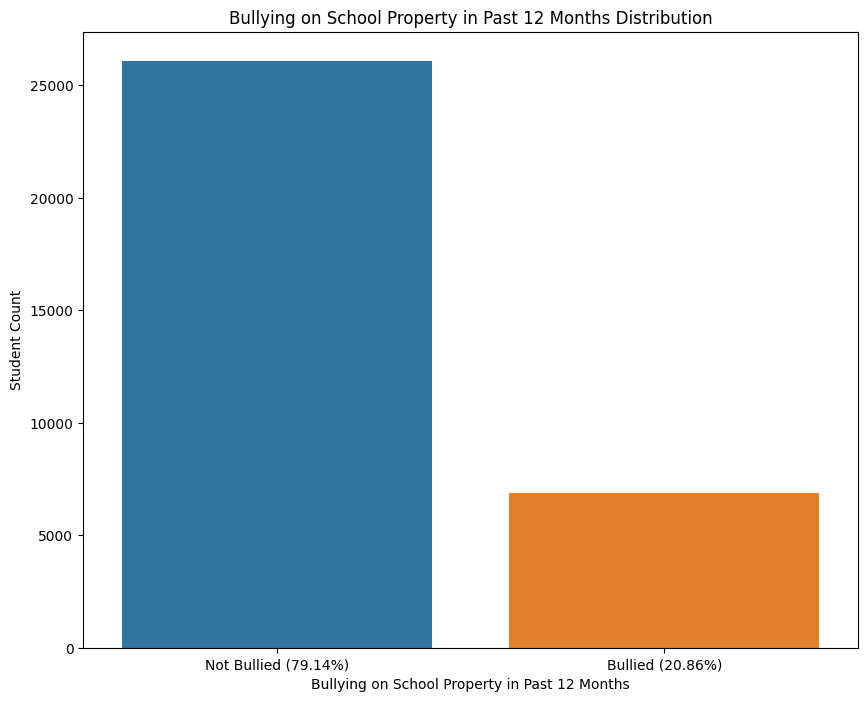

In [10]:
# Target Variable distribution plot
bullied = train_df['Bullied_on_school_property_in_past_12_months'].value_counts()[1]
not_bullied = train_df['Bullied_on_school_property_in_past_12_months'].value_counts()[0]
total = train_df.shape[0]

print(f"Bullied percentage : {bullied/total *100 :.2f}% ")
print(f"Not Bullied percentage : {not_bullied/total *100 :.2f}% ")

plt.figure(figsize=(10,8))
sns.countplot(x='Bullied_on_school_property_in_past_12_months', data=train_df)

plt.title('Bullying on School Property in Past 12 Months Distribution')
plt.xlabel("Bullying on School Property in Past 12 Months")
plt.ylabel("Student Count")

_ = plt.xticks((0, 1), ['Not Bullied ({0:.2f}%)'.format(not_bullied/total *100), 'Bullied ({0:.2f}%)'.format(bullied/total *100)])

# Our data on bullied farily low with 20.86 % compare to not bullied 79.14%. Even though with methods like Smote we can balance the data, as we looked at literature and impalmentetion of it on datasets 
it does not really provide any additonal value for our model performance, we should be using precision recall and f1 score as our evaluation metrics. as we are more interested in correctly predicting the bullied students. Even tough labeling a student with bullued on a not bullied student 
its apperent that the student with bullied will misslacisied its a very much worse sneciro so we should be using recall in this senario as our primary evaluation metrics
with precision and f1 as our secondary evaluation metrics.


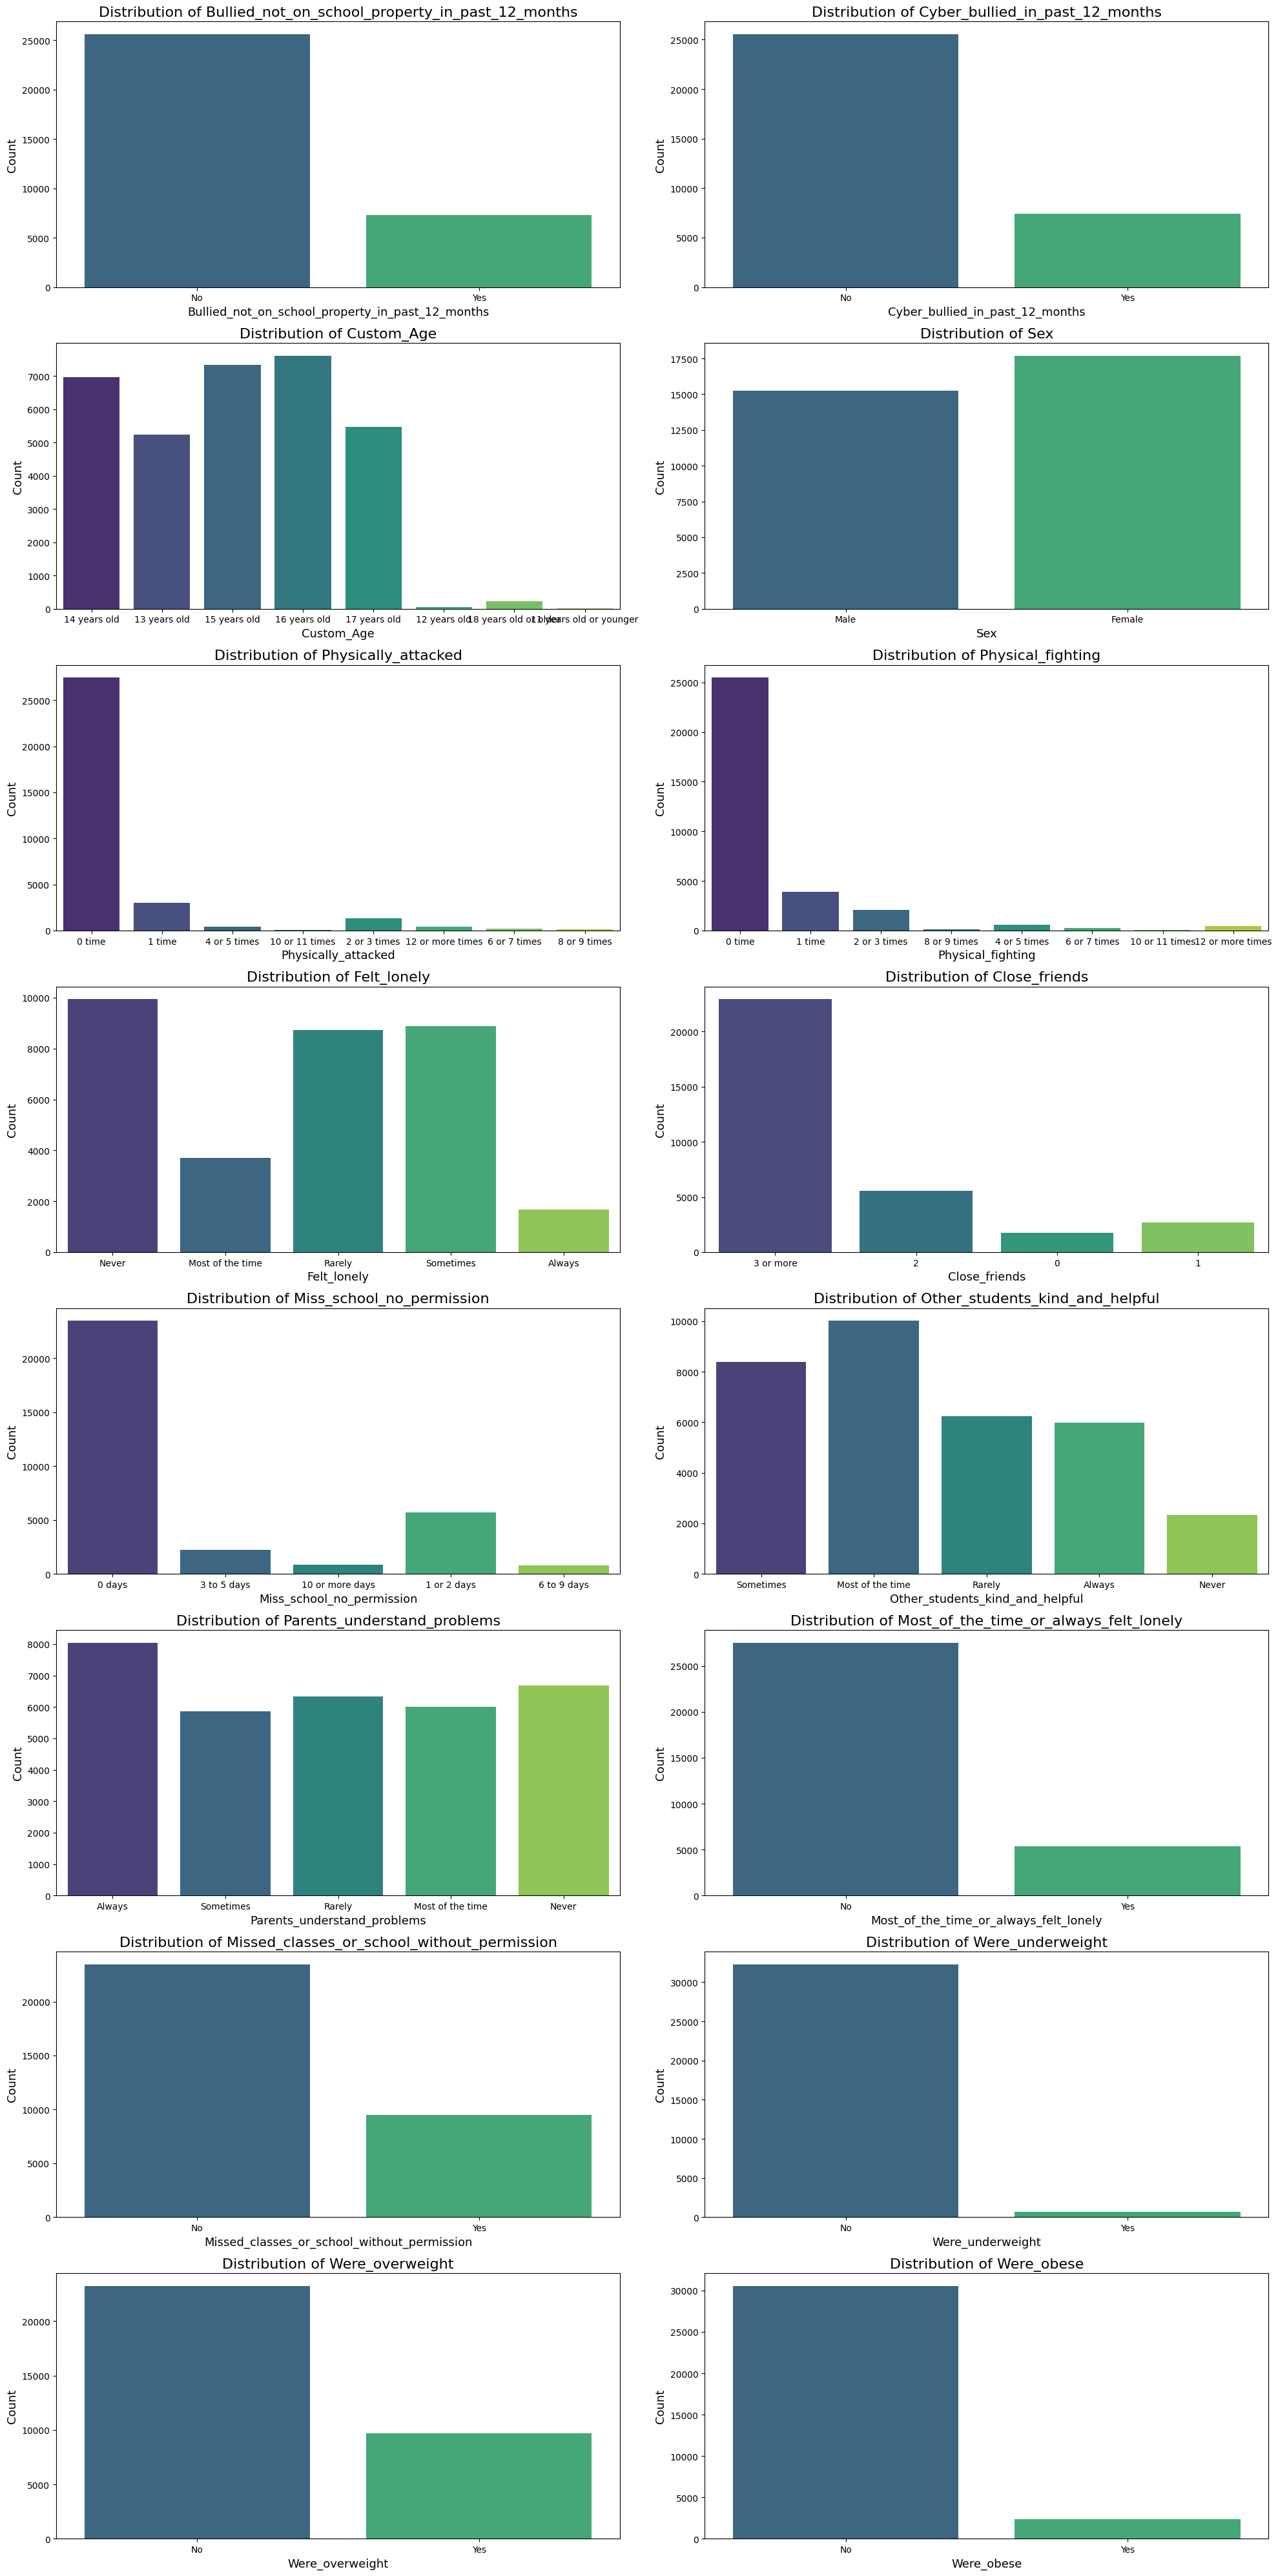

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of all columns excluding 'record' and target column
columns = [col for col in train_df.columns if col not in ['record', 'Bullied_on_school_property_in_past_12_months']]

# Calculate number of rows needed for plots
n_rows = len(columns) // 2 if len(columns) % 2 == 0 else len(columns) // 2 + 1

# Create subplots
fig, ax = plt.subplots(nrows=n_rows, ncols=2, figsize=(20, n_rows*5))
ax = ax.ravel()  # Flatten the ax array

# Create a countplot for each column
for i in range(len(columns)):
    sns.countplot(data=train_df, x=columns[i], ax=ax[i], palette='viridis')
    ax[i].set_title(f'Distribution of {columns[i]}', fontsize=16)
    ax[i].set_xlabel(columns[i], fontsize=13)
    ax[i].set_ylabel('Count', fontsize=13)

# Remove empty subplots
if len(columns) % 2 != 0:
    fig.delaxes(ax[-1])

plt.tight_layout()
plt.show()

As we have guessed 
when we looked at the distrubution of the variables regarding the target variable 
we have see that bullid not_on_school_rpoptery and cyber bullied are highly correlated to find the bullied students 
with a very even distrubution of the target variable when yes  compare to other variables 
as we looked age column there is not a clear high indicator of bullied in a specific age group
and they are pretty much at a similiar level of distrubution
as we have looked at sex there is also not a clear level of distrubution between male and female 
maybe the interplation of 2 or more variables with respected to their age could be a good insight 
as age group and sex combined could be a good indicator for the model 
pyhsically attacked is a good indicator for our model as we see the distrubitions are high after 0 means non attacked 
pyshicall fighting is not has a very good indicator as phisyccal attacked as we see but still could be valuable variable with the combination of other variables 
felt lonely looks a really good columns as we can see with most of the time and always has a clear indicator of getting bullied compare to the other classes column 
and has a high change of getting bullied on those values 
when we looked at the close firend counts there is a small relation with the target variable compare to what we expected as close firend counts 
could be good indicator for our model bot as much we expected 
parents understand problems is looking very evenly distrubuited accross all clases and probably wont be a helpful indicator for our model based on these graphs 
but we will be looking at the correlations moving forward to see if we missed anything 
kind and helpful looks like a good indicator for our model as there is a clear distinction between distrubutions for target variable acrros classes 
with most of the time and always has good  chance of getting bullied
felt lonely is looking a very good indicator second to only bullied not on school property and cyber bullied with a very high change of getting bullied 
in the posivite class of felt lonely 
for the weight classes we have still a similar distrubutions of the target variable accross classes even though the distrubution of the positivie classes in the weight expected way higher





Upon analyzing the distribution of variables in relation to the target variable, we observed that 'bullied_not_on_school_property' and 'cyber_bullied' are highly correlated with identifying bullied students. These variables exhibit a balanced distribution for the 'Yes' class compared to other variables.

When examining the 'age' column, we did not find a specific age group that stood out as being more prone to bullying. The distribution across different ages was relatively similar.

The 'sex' column also did not show a clear distinction between males and females in terms of bullying. However, combining 'age' and 'sex' might provide valuable insights and serve as a good indicator for our model.

'Physically_attacked' appears to be a good indicator for our model, as the distribution is significantly higher for non-zero values. 'Physical_fighting', while not as strong an indicator as 'physically_attacked', could still be a valuable variable when combined with others.

'Felt_lonely' is a promising variable, as 'most of the time' and 'always' classes show a clear indication of bullying compared to other classes. This variable has a high chance of identifying bullied students.

When we examined 'close_friend_counts', the relationship with the target variable was smaller than expected. While we initially thought that 'close_friend_counts' could be a good indicator for our model, it did not meet our expectations.

'Parents_understand_problems' is evenly distributed across all classes and may not be a helpful indicator for our model based on these graphs. However, we will further investigate correlations to ensure we have not overlooked anything.

'Kind_and_helpful' seems to be a good indicator for our model, as there is a clear distinction in the distribution of the target variable across classes. The 'most of the time' and 'always' classes have a good chance of identifying bullied students.

'Felt_lonely' is a very strong indicator, second only to 'bullied_not_on_school_property' and 'cyber_bullied'. Students who often or always feel lonely have a high chance of being bullied.

For the 'weight' classes, the distribution of the target variable across classes is similar, even though we expected a higher distribution in the positive classes.

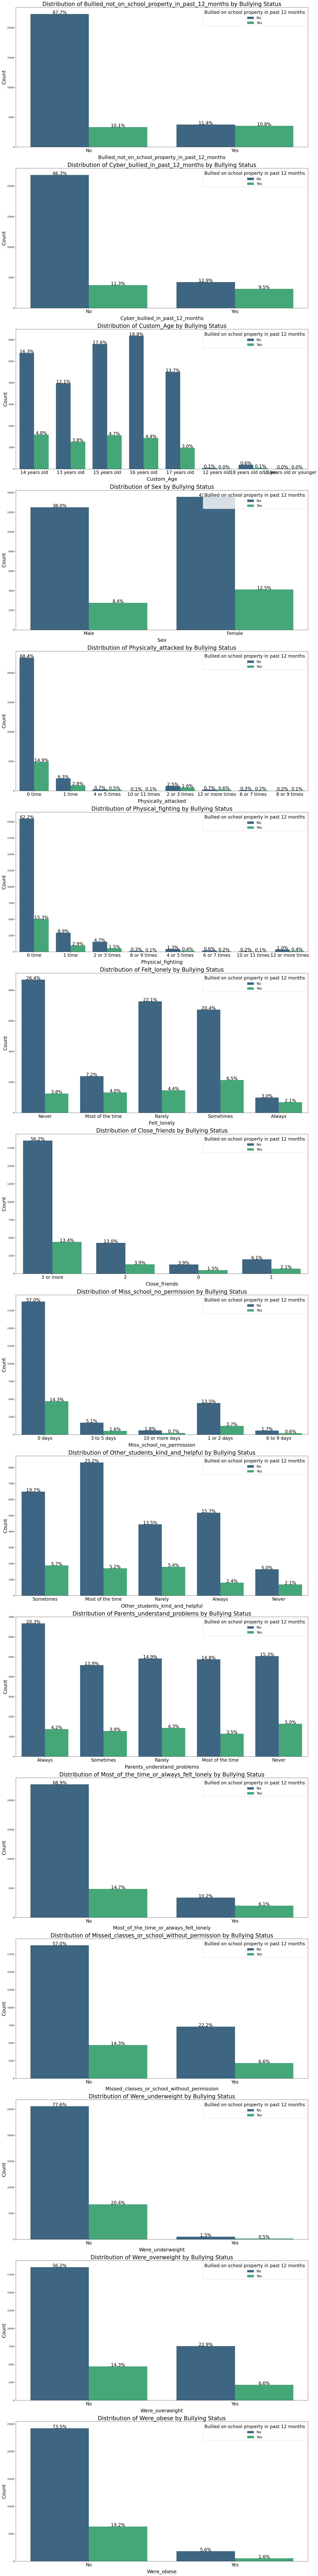

In [11]:
import matplotlib.ticker as mticker

# List of all columns excluding 'record' and target column
columns = [col for col in train_df.columns if col not in ['record', 'Bullied_on_school_property_in_past_12_months']]

# Create subplots
fig, ax = plt.subplots(len(columns), 1, figsize=(20, len(columns)*10))

# Create a countplot for each column
for i, col in enumerate(columns):
    sns.countplot(data=train_df, x=col, hue='Bullied_on_school_property_in_past_12_months', palette='viridis', ax=ax[i])
    ax[i].set_title(f'Distribution of {col} by Bullying Status', fontsize=25)
    ax[i].set_xlabel(col, fontsize=22)
    ax[i].set_ylabel('Count', fontsize=22)
    ax[i].xaxis.set_major_locator(mticker.MultipleLocator(1))  # Ensure x-axis labels don't overlap
    ax[i].legend(title='Bullied on school property in past 12 months', title_fontsize='20', labels=['No', 'Yes'], fontsize='15')
    ax[i].xaxis.labelpad = 10  # Add padding to x-axis labels
    ax[i].tick_params(axis='x', labelsize=20)  # Increase x-axis label fontsize

    # Add percentage on top of each bar
    total = len(train_df[col])
    for p in ax[i].patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy() 
        percentage = f'{100 * height/total:.1f}%'
        ax[i].annotate(percentage, (x + width/2, y + height), ha='center', fontsize=20)

    # Modify x-axis labels for 'age' column
    if col == 'age':
        ax[i].set_xticklabels([label.get_text().split(' ')[0] for label in ax[i].get_xticklabels()])

plt.tight_layout()
plt.show()


In [ ]:
#FEATURE ENGINEERING 
# EXTRACTING VALUES FROM Custom_Age ,Pysically attacked , Physical_fghitng,

In [9]:
# # Ordinal Encdoing for felt_lonely,other_students_kind_and_helpful,parents_understand_problems
#we will be using ordinal encoding for the following columns as they are ordinal variables and we will be using ordinal encoding for them.
train_df['Custom_Age'] = train_df['Custom_Age'].apply(extract_age)
train_df = encode_all_ordinal(train_df,times_columns=['Physical_fighting','Physically_attacked'],days_columns=['Miss_school_no_permission'],numbers_columns=['Close_friends'],feelings_columns=['Felt_lonely','Other_students_kind_and_helpful','Parents_understand_problems'])
train_df = encode_binary(train_df, columns=['Bullied_on_school_property_in_past_12_months','Bullied_not_on_school_property_in_past_12_months','Cyber_bullied_in_past_12_months','Most_of_the_time_or_always_felt_lonely','Missed_classes_or_school_without_permission','Were_underweight','Were_overweight','Were_obese'])
train_df = categorical_encoding(train_df,categorical_variables=['Sex'])

In [13]:
train_df

record  Bullied_on_school_property_in_past_12_months  \
0           1                                             0   
1           2                                             0   
2           3                                             0   
3           4                                             0   
4           5                                             0   
...       ...                                           ...   
32933   32934                                             0   
32934   32935                                             0   
32935   32936                                             0   
32936   32937                                             0   
32937   32938                                             0   

       Bullied_not_on_school_property_in_past_12_months  \
0                                                     0   
1                                                     0   
2                                                     0   
3                                                     0   
4                                                     0   
...                                                 ...   
32933                                                 1   
32934                                                 0   
32935                                                 0   
32936                                                 1   
32937                                                 1   

       Cyber_bullied_in_past_12_months  Custom_Age  Physically_attacked  \
0                                    0          14                    0   
1                                    0          13                    0   
2                                    0          15                    0   
3                                    1          13                    0   
4                                    0          14                    0   
...                                ...         ...                  ...   
32933                                0          16                    0   
32934                                0          16                    0   
32935                                1          15                    7   
32936                                0          16                    0   
32937                                1          16                    0   

       Physical_fighting  Felt_lonely  Close_friends  \
0                      0          0.0              3   
1                      1          0.0              3   
2                      1          0.0              3   
3                      2          3.0              3   
4                      2          3.0              2   
...                  ...          ...            ...   
32933                  0          1.0              3   
32934                  2          0.0              3   
32935                  2          1.0              3   
32936                  3          2.0              3   
32937                  0          4.0              2   

       Miss_school_no_permission  Other_students_kind_and_helpful  \
0                              0                              2.0   
1                              0                              3.0   
2                              2                              3.0   
3                              0                              1.0   
4                              0                              4.0   
...                          ...                              ...   
32933                          2                              1.0   
32934                          0                              2.0   
32935                          0                              3.0   
32936                          0                              2.0   
32937                          1                              1.0   

       Parents_understand_problems  Most_of_the_time_or_always_felt_lonely  \
0                              4.0                          

In [8]:
train_df = pd.read_excel('../data/PowerBI-Raw_data.xlsx')

In [9]:
train_df

record Bullied_on_school_property_in_past_12_months  \
0           1                                           No   
1           2                                           No   
2           3                                           No   
3           4                                           No   
4           5                                           No   
...       ...                                          ...   
32933   32934                                           No   
32934   32935                                           No   
32935   32936                                           No   
32936   32937                                           No   
32937   32938                                           No   

      Bullied_not_on_school_property_in_past_12_months  \
0                                                   No   
1                                                   No   
2                                                   No   
3                                                   No   
4                                                   No   
...                                                ...   
32933                                              Yes   
32934                                               No   
32935                                               No   
32936                                              Yes   
32937                                              Yes   

      Cyber_bullied_in_past_12_months    Custom_Age     Sex  \
0                                  No  14 years old    Male   
1                                  No  13 years old    Male   
2                                  No  15 years old    Male   
3                                 Yes  13 years old    Male   
4                                  No  14 years old    Male   
...                               ...           ...     ...   
32933                              No  16 years old    Male   
32934                              No  16 years old    Male   
32935                             Yes  15 years old    Male   
32936                              No  16 years old    Male   
32937                             Yes  16 years old  Female   

      Physically_attacked Physical_fighting       Felt_lonely Close_friends  \
0                  0 time            0 time             Never     3 or more   
1                  0 time            1 time             Never     3 or more   
2                  0 time            1 time             Never     3 or more   
3                  0 time      2 or 3 times  Most of the time     3 or more   
4                  0 time      2 or 3 times  Most of the time             2   
...                   ...               ...               ...           ...   
32933              0 time            0 time            Rarely     3 or more   
32934              0 time      2 or 3 times             Never     3 or more   
32935    12 or more times      2 or 3 times            Rarely     3 or more   
32936              0 time      4 or 5 times         Sometimes     3 or more   
32937              0 time            0 time            Always             2   

      Miss_school_no_permission Other_students_kind_and_helpful  \
0                        0 days                       Sometimes   
1                        0 days                Most of the time   
2                   3 to 5 days                Most of the time   
3                        0 days                          Rarely   
4                        0 days                          Always   
...                         ...                             ...   
32933               3 to 5 days                          Rarely   
32934                    0 days                       Sometimes   
32935                    0 days                Most of the time   
32936                    0 days                       Sometimes   
32937               1 or 2 days                          Rarely   

      Parents_understand_problems Most_of_the_time_or_

In [11]:
# Define the pipeline
pipeline = Pipeline(steps=[
    ('age_extractor', AgeExtractor('Custom_Age')),
    ('ordinal_encoder', OrdinalEncoderCustom(times_columns=['Physical_fighting','Physically_attacked'], days_columns=['Miss_school_no_permission'], numbers_columns=['Close_friends'], 
                                             feelings_columns=['Felt_lonely','Other_students_kind_and_helpful','Parents_understand_problems'])),
    ('binary_encoder', BinaryEncoderCustom(columns=['Bullied_on_school_property_in_past_12_months','Bullied_not_on_school_property_in_past_12_months','Cyber_bullied_in_past_12_months',
                                                    'Most_of_the_time_or_always_felt_lonely','Missed_classes_or_school_without_permission','Were_underweight','Were_overweight','Were_obese'])),
    ('categorical_encoder', CategoricalEncoder(categorical_variables=['Sex'])),
    ('selector', DataFrameSelector(attribute_names=['record','Bullied_on_school_property_in_past_12_months', 'Bullied_not_on_school_property_in_past_12_months','Cyber_bullied_in_past_12_months',
                                                    'Custom_Age','Physically_attacked','Physical_fighting','Felt_lonely','Close_friends','Miss_school_no_permission','Other_students_kind_and_helpful',
                                                    'Parents_understand_problems','Most_of_the_time_or_always_felt_lonely','Missed_classes_or_school_without_permission','Were_underweight',
                                                    'Were_obese']))
])

# Use the pipeline
transformed_train_df = pipeline.fit_transform(train_df)

In [12]:
transformed_train_df

record  Bullied_on_school_property_in_past_12_months  \
0           1                                             0   
1           2                                             0   
2           3                                             0   
3           4                                             0   
4           5                                             0   
...       ...                                           ...   
32933   32934                                             0   
32934   32935                                             0   
32935   32936                                             0   
32936   32937                                             0   
32937   32938                                             0   

       Bullied_not_on_school_property_in_past_12_months  \
0                                                     0   
1                                                     0   
2                                                     0   
3                                                     0   
4                                                     0   
...                                                 ...   
32933                                                 1   
32934                                                 0   
32935                                                 0   
32936                                                 1   
32937                                                 1   

       Cyber_bullied_in_past_12_months  Custom_Age  Physically_attacked  \
0                                    0          14                    0   
1                                    0          13                    0   
2                                    0          15                    0   
3                                    1          13                    0   
4                                    0          14                    0   
...                                ...         ...                  ...   
32933                                0          16                    0   
32934                                0          16                    0   
32935                                1          15                    7   
32936                                0          16                    0   
32937                                1          16                    0   

       Physical_fighting  Felt_lonely  Close_friends  \
0                      0          0.0              3   
1                      1          0.0              3   
2                      1          0.0              3   
3                      2          3.0              3   
4                      2          3.0              2   
...                  ...          ...            ...   
32933                  0          1.0              3   
32934                  2          0.0              3   
32935                  2          1.0              3   
32936                  3          2.0              3   
32937                  0          4.0              2   

       Miss_school_no_permission  Other_students_kind_and_helpful  \
0                              0                              2.0   
1                              0                              3.0   
2                              2                              3.0   
3                              0                              1.0   
4                              0                              4.0   
...                          ...                              ...   
32933                          2                              1.0   
32934                          0                              2.0   
32935                          0                              3.0   
32936                          0                              2.0   
32937                          1                              1.0   

       Parents_understand_problems  Most_of_the_time_or_always_felt_lonely  \
0                              4.0                          

In [13]:
"""new_data = pd.read_csv('new_data.csv')  # replace with the path to your CSV file

# Separate the 'record' column
record = new_data['record']
new_data = new_data.drop('record', axis=1)

# Transform the data using the pipeline
transformed_data = pipeline.transform(new_data)

# Make predictions using your model
predictions = model.predict(transformed_data)
"""

"new_data = pd.read_csv('new_data.csv')  # replace with the path to your CSV file\n\n# Separate the 'record' column\nrecord = new_data['record']\nnew_data = new_data.drop('record', axis=1)\n\n# Transform the data using the pipeline\ntransformed_data = pipeline.transform(new_data)\n\n# Make predictions using your model\npredictions = model.predict(transformed_data)\n"

In [13]:
record = transformed_train_df['record']
transformed_train_df = transformed_train_df.drop('record', axis=1)

train_x, train_y, validation_x, validation_y = prepare_data(transformed_train_df, 'Bullied_on_school_property_in_past_12_months')

train_x['record'] = record.loc[train_x.index]
validation_x['record'] = record.loc[validation_x.index]

train_record = train_x['record']
validation_record = validation_x['record']

train_record = train_x['record']
validation_record = validation_x['record']

train_x = train_x.drop('record', axis=1)
validation_x = validation_x.drop('record', axis=1)

train_x.reset_index(drop=True, inplace=True)
train_y.reset_index(drop=True, inplace=True)
validation_x.reset_index(drop=True, inplace=True)
validation_y.reset_index(drop=True, inplace=True)


In [17]:
train_x

Bullied_not_on_school_property_in_past_12_months  \
0                                                     0   
1                                                     0   
2                                                     0   
3                                                     1   
4                                                     0   
...                                                 ...   
29639                                                 0   
29640                                                 0   
29641                                                 0   
29642                                                 0   
29643                                                 0   

       Cyber_bullied_in_past_12_months  Custom_Age  Physically_attacked  \
0                                    0          13                    1   
1                                    0          15                    0   
2                                    0          15                    1   
3                                    0          13                    3   
4                                    0          16                    0   
...                                ...         ...                  ...   
29639                                0          15                    0   
29640                                0          16                    0   
29641                                0          13                    0   
29642                                0          14                    0   
29643                                0          16                    0   

       Physical_fighting  Felt_lonely  Close_friends  \
0                      1          1.0              0   
1                      0          2.0              3   
2                      0          4.0              3   
3                      0          1.0              0   
4                      0          1.0              3   
...                  ...          ...            ...   
29639                  0          0.0              2   
29640                  0          3.0              1   
29641                  0          0.0              3   
29642                  0          2.0              3   
29643                  0          1.0              1   

       Miss_school_no_permission  Other_students_kind_and_helpful  \
0                              0                              0.0   
1                              0                              2.0   
2                              0                              1.0   
3                              0                              4.0   
4                              0                              2.0   
...                          ...                              ...   
29639                          2                              2.0   
29640                          0                              2.0   
29641                          0                              2.0   
29642                          0                              2.0   
29643                          0                              4.0   

       Parents_understand_problems  Most_of_the_time_or_always_felt_lonely  \
0                              0.0                                       0   
1                              1.0                                       0   
2                              1.0                                       1   
3                              0.0                                       0   
4                              3.0                                       0   
...                            ...                                     ...   
29639                          2.0                                       0   
29640                          1.0                                       1   
29641                          4.0                                       0   
29642                          0.0                                       0   
29643                          0.0   

In [16]:
XGB  = XGBClassifier()

In [17]:
XGB.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [18]:
from imblearn.over_sampling import SMOTE

# Create a SMOTE object
smote = SMOTE()

X_train_resampled, y_train_resampled = smote.fit_resample(train_x, train_y)




In [22]:
from sklearn.metrics import confusion_matrix
def objective(trial):
    optuna.logging.set_verbosity(optuna.logging.INFO)

    classifier_name = trial.suggest_categorical("classifier",["XGB","LGBM","RF"])
    
    if classifier_name == "XGB":
        params = {
            "objective": "binary:logistic",
            "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
            "verbosity": 0,
            "learning_rate": trial.suggest_float("xgb_learning_rate", 0.01, 0.2),
            "max_depth": trial.suggest_int("xgb_max_depth", 2,8),
            "colsample_bytree": trial.suggest_float("xgb_colsample_bytree", 0.7, 1.0),
            "subsample": trial.suggest_float("xgb_subsample", 0.6, 1.0),
            "min_child_weight": trial.suggest_int("xgb_min_child_weight", 3,8),
        }
        model = XGBClassifier(**params)
    elif classifier_name == "LGBM":
        params = {
            "objective": "binary",
            "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
            "learning_rate": trial.suggest_float("lgbm_learning_rate", 0.01, 0.2),
            "max_depth": trial.suggest_int("lgbm_max_depth", 2,8),
            "num_leaves": trial.suggest_int("lgbm_num_leaves", 31, 256),
            "subsample": trial.suggest_float("lgbm_subsample", 0.6, 1.0),
            "verbose": -1
        }
        model = LGBMClassifier(**params)
    else:
        params = {
            "n_estimators": 1000,
            "max_depth": trial.suggest_int("rf_max_depth", 2,8),
            "min_samples_split": trial.suggest_int("rf_min_samples_split", 2, 15),
        }
        model = RandomForestClassifier(**params)

        
        
    skf = StratifiedKFold(n_splits=5)
    recalls = []
    f1s = []
    precisions = []
    accuracies = []
    overall_y_val = []
    overall_predictions = []
    
    for train_index, val_index in skf.split(X_train_resampled, y_train_resampled):
        X_train, X_val = X_train_resampled.iloc[train_index], X_train_resampled.iloc[val_index]
        y_train, y_val = y_train_resampled[train_index], y_train_resampled[val_index]
        
        if classifier_name =="XGB":
            model.fit(X_train, y_train, eval_set=[(X_val, y_val)],verbose = False)
        elif classifier_name == "LGBM":
            model.fit(X_train, y_train, eval_set=[(X_val, y_val)],eval_metric='auc')
        else:  # RandomForest
            model.fit(X_train, y_train)
        predictions = model.predict(X_val)
        precision = precision_score(y_val, predictions, average='macro')
        recall = recall_score(y_val, predictions, average='binary')
        f1 = f1_score(y_val, predictions, average='binary')
        overall_y_val.extend(y_val)
        overall_predictions.extend(predictions)
        accuracy = accuracy_score(y_val, predictions)
        accuracies.append(accuracy)
        recalls.append(recall)
        f1s.append(f1)
        precisions.append(precision)
        
    if trial.number % 3 == 0:
        cm = confusion_matrix(overall_y_val, overall_predictions)
        plt.figure(figsize=(10,7))
        sns.heatmap(cm, annot=True, fmt='d')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        if classifier_name == "XGB":
            xgb.plot_importance(model, importance_type='gain', title=f'{classifier_name} - Feature importance by gain')
            xgb.plot_importance(model, importance_type='weight', title=f'{classifier_name} - Feature importance by weight')

        elif classifier_name == "LGBM":
            lgb.plot_importance(model, importance_type='gain', title=f'{classifier_name} - Feature importance by gain')
            lgb.plot_importance(model, importance_type='split', title=f'{classifier_name} - Feature importance by split')        
        else:  # RandomForest
            importances = model.feature_importances_
            indices = np.argsort(importances)[::-1]
            plt.figure(figsize=(12, 6))
            plt.title(f'{classifier_name} - Feature importance')
            plt.bar(range(train_x.shape[1]), importances[indices])
            plt.xticks(range(train_x.shape[1]), train_x.columns[indices], rotation=90)
    
    print(f"Mean Accuracy: {np.mean(accuracies)}")
    print(f"Mean Precision: {np.mean(precision)}")
    print(f"Mean Recall: {np.mean(recalls)}")
    print(f"Mean F1 Score: {np.mean(f1s)}")
    
    
    return np.mean(recalls)

[I 2023-12-16 17:51:50,907] A new study created in memory with name: no-name-f0986b97-f12f-4939-b603-eb7bd075740a


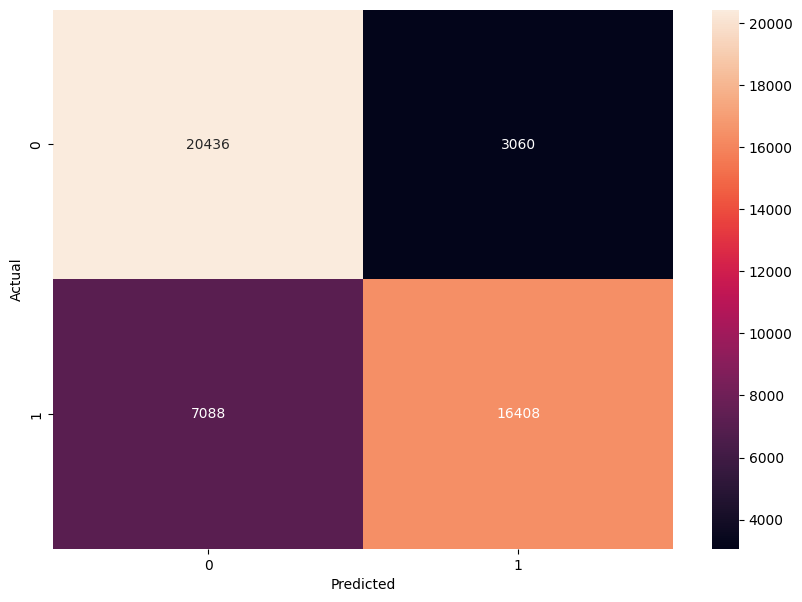

[I 2023-12-16 17:51:56,828] Trial 0 finished with value: 0.6983313063440388 and parameters: {'classifier': 'LGBM', 'n_estimators': 693, 'lgbm_learning_rate': 0.045962034231285157, 'lgbm_max_depth': 5, 'lgbm_num_leaves': 122, 'lgbm_subsample': 0.7301828995993408}. Best is trial 0 with value: 0.6983313063440388.


Mean Accuracy: 0.7840509446416591
Mean Precision: 0.8265863253886412
Mean Recall: 0.6983313063440388
Mean F1 Score: 0.7541419847650269


[I 2023-12-16 17:52:00,289] Trial 1 finished with value: 0.6940326733166404 and parameters: {'classifier': 'LGBM', 'n_estimators': 448, 'lgbm_learning_rate': 0.1324588322855258, 'lgbm_max_depth': 4, 'lgbm_num_leaves': 106, 'lgbm_subsample': 0.6821663969070033}. Best is trial 0 with value: 0.6983313063440388.


Mean Accuracy: 0.7813271306295778
Mean Precision: 0.8230930180175564
Mean Recall: 0.6940326733166404
Mean F1 Score: 0.7505109445064958


[I 2023-12-16 17:52:05,524] Trial 2 finished with value: 0.6836477204294259 and parameters: {'classifier': 'LGBM', 'n_estimators': 901, 'lgbm_learning_rate': 0.07115781839021092, 'lgbm_max_depth': 3, 'lgbm_num_leaves': 56, 'lgbm_subsample': 0.6207971714734446}. Best is trial 0 with value: 0.6983313063440388.


Mean Accuracy: 0.777369006917803
Mean Precision: 0.8189396775768563
Mean Recall: 0.6836477204294259
Mean F1 Score: 0.7442348001520229


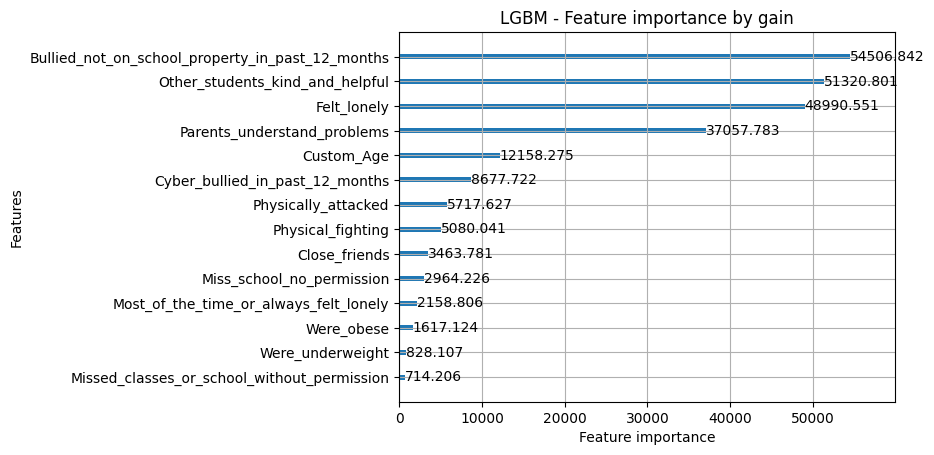

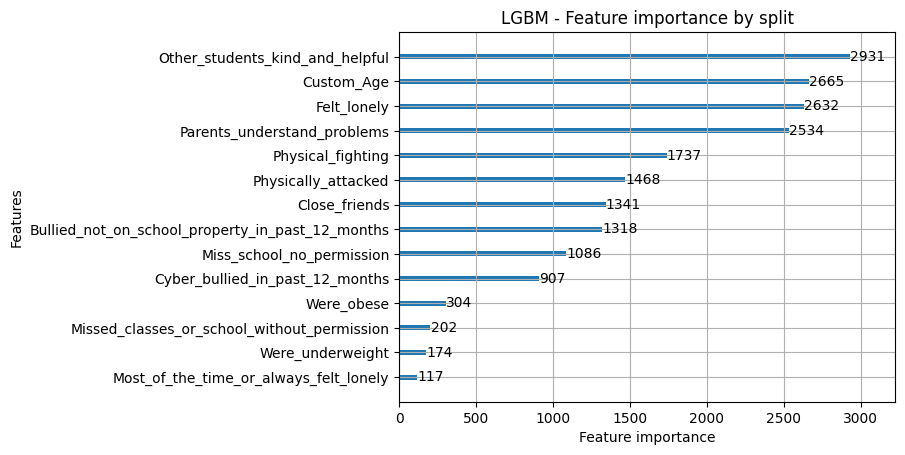

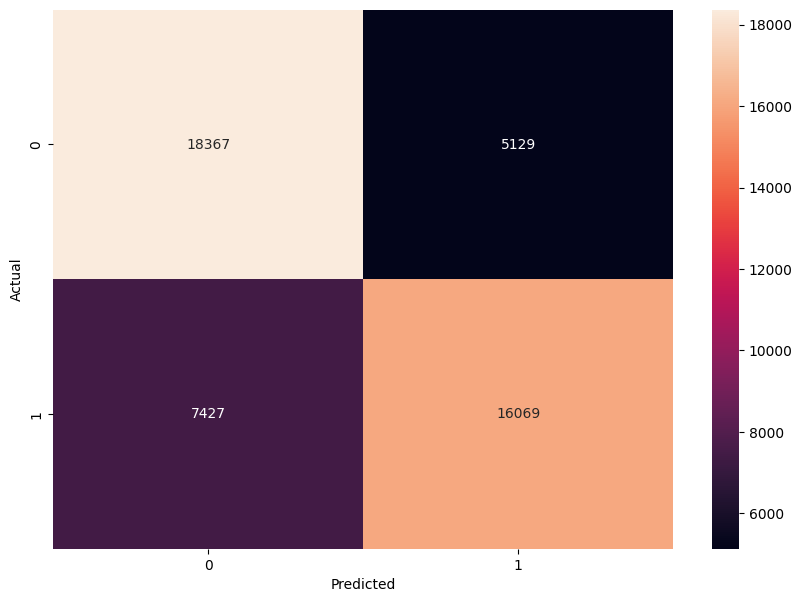

[I 2023-12-16 17:53:10,357] Trial 3 finished with value: 0.6839036553725781 and parameters: {'classifier': 'RF', 'rf_max_depth': 8, 'rf_min_samples_split': 5}. Best is trial 0 with value: 0.6983313063440388.


Mean Accuracy: 0.732806166458599
Mean Precision: 0.74151711073196
Mean Recall: 0.6839036553725781
Mean F1 Score: 0.7188010844375118


[I 2023-12-16 17:53:53,510] Trial 4 finished with value: 0.6575161396947291 and parameters: {'classifier': 'RF', 'rf_max_depth': 4, 'rf_min_samples_split': 4}. Best is trial 0 with value: 0.6983313063440388.


Mean Accuracy: 0.7030771227784983
Mean Precision: 0.7042483030884852
Mean Recall: 0.6575161396947291
Mean F1 Score: 0.6888990749455549


[I 2023-12-16 17:54:00,805] Trial 5 finished with value: 0.7043751092355549 and parameters: {'classifier': 'LGBM', 'n_estimators': 863, 'lgbm_learning_rate': 0.1866721453671135, 'lgbm_max_depth': 4, 'lgbm_num_leaves': 220, 'lgbm_subsample': 0.9929806947360195}. Best is trial 5 with value: 0.7043751092355549.


Mean Accuracy: 0.7864769542457652
Mean Precision: 0.8274859015006186
Mean Recall: 0.7043751092355549
Mean F1 Score: 0.7573976821098143


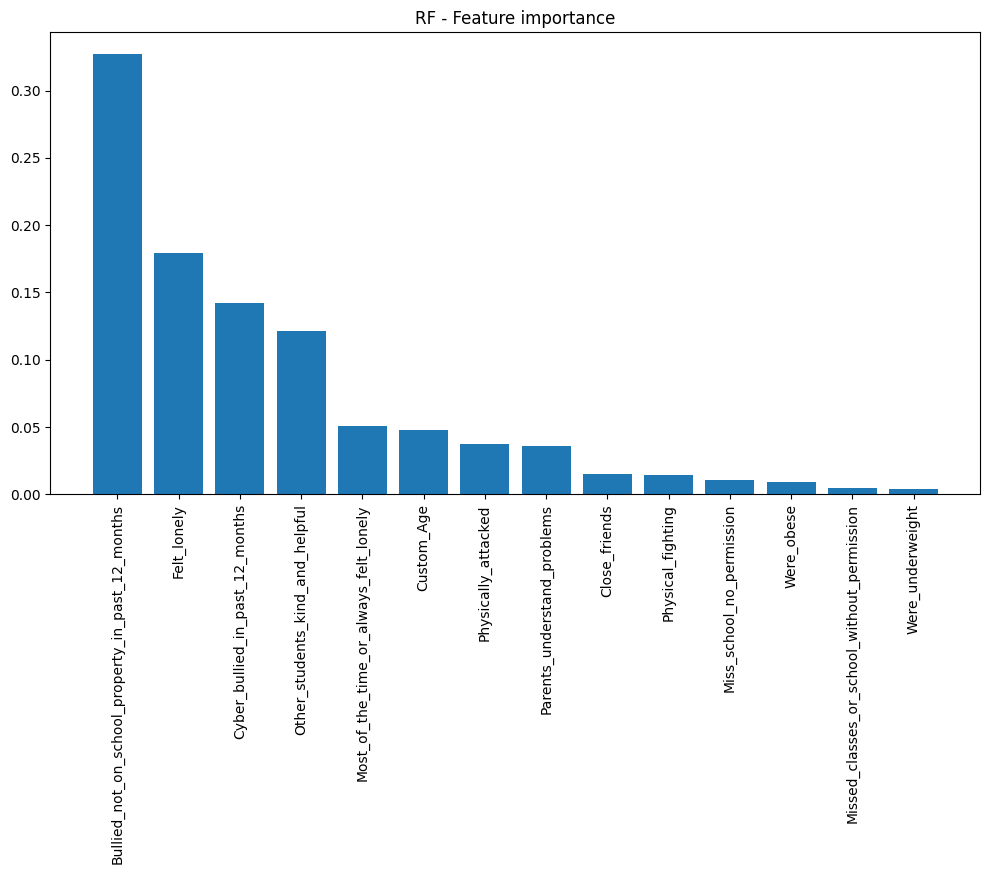

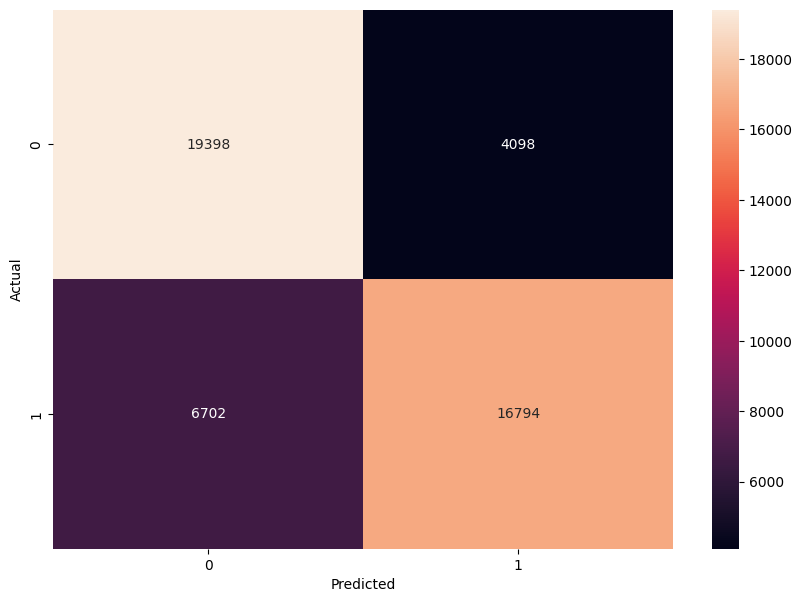

[I 2023-12-16 17:54:08,536] Trial 6 finished with value: 0.7147600077879857 and parameters: {'classifier': 'XGB', 'n_estimators': 302, 'xgb_learning_rate': 0.015164655227286746, 'xgb_max_depth': 6, 'xgb_colsample_bytree': 0.8736562273848671, 'xgb_subsample': 0.8087522018465994, 'xgb_min_child_weight': 5}. Best is trial 6 with value: 0.7147600077879857.


Mean Accuracy: 0.7701754550416622
Mean Precision: 0.7972409483218985
Mean Recall: 0.7147600077879857
Mean F1 Score: 0.7533449096653416


[I 2023-12-16 17:54:44,331] Trial 7 finished with value: 0.6401515849909216 and parameters: {'classifier': 'RF', 'rf_max_depth': 2, 'rf_min_samples_split': 3}. Best is trial 6 with value: 0.7147600077879857.


Mean Accuracy: 0.6915003726517431
Mean Precision: 0.6866050400701572
Mean Recall: 0.6401515849909216
Mean F1 Score: 0.6746914008201306


[I 2023-12-16 17:54:45,165] Trial 8 finished with value: 0.7096950098029005 and parameters: {'classifier': 'LGBM', 'n_estimators': 107, 'lgbm_learning_rate': 0.19338738049820486, 'lgbm_max_depth': 2, 'lgbm_num_leaves': 230, 'lgbm_subsample': 0.6568087748510407}. Best is trial 6 with value: 0.7147600077879857.


Mean Accuracy: 0.7723036647661734
Mean Precision: 0.8059730461845105
Mean Recall: 0.7096950098029005
Mean F1 Score: 0.7521606781542061


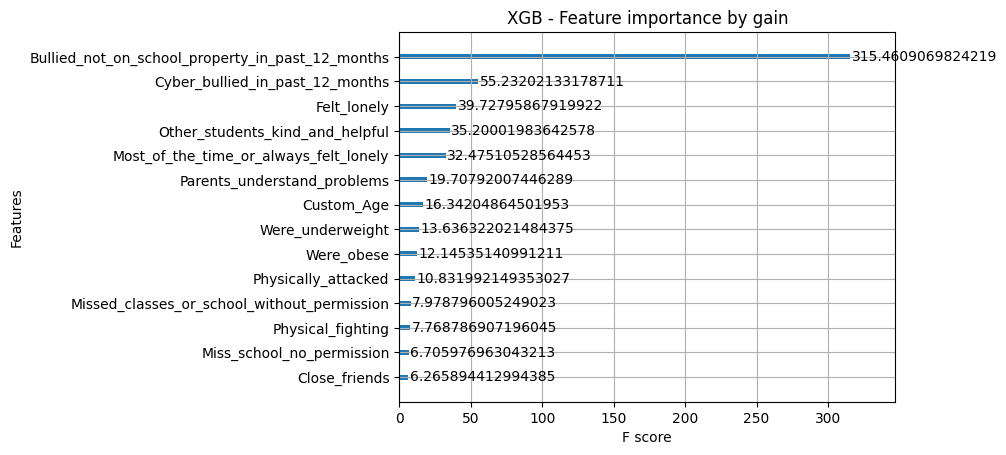

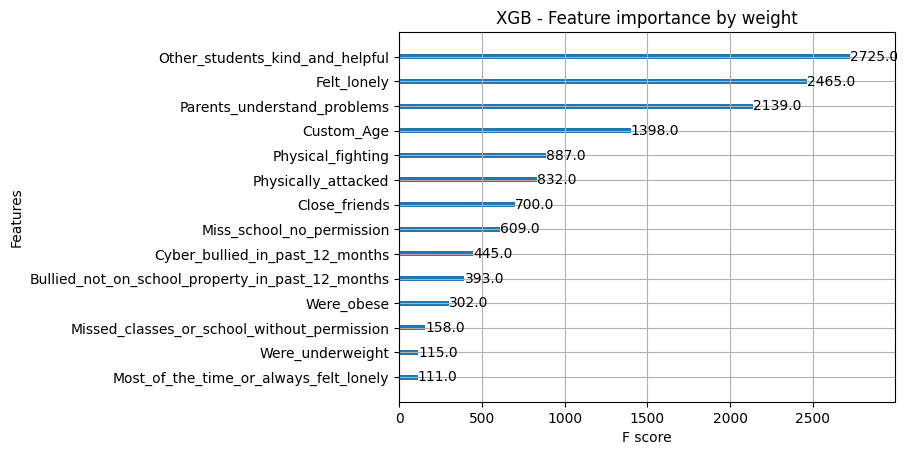

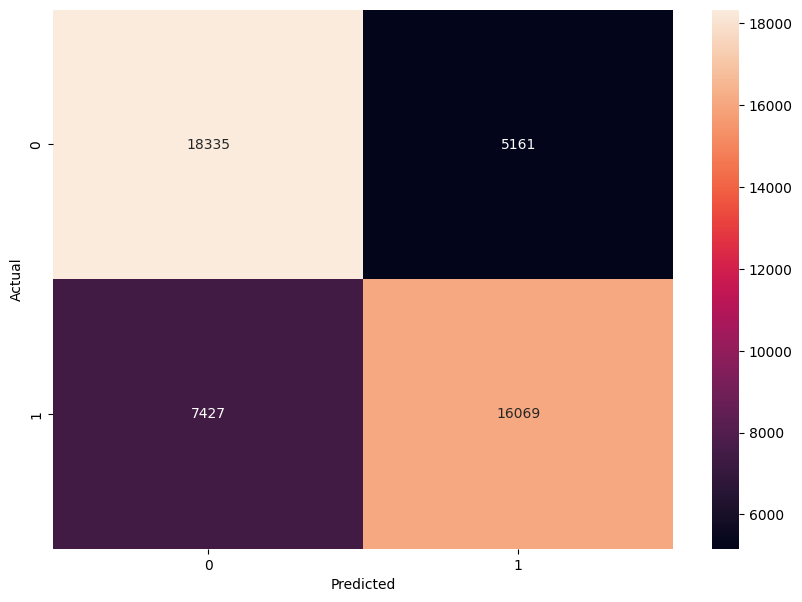

[I 2023-12-16 17:55:53,738] Trial 9 finished with value: 0.6839035557588079 and parameters: {'classifier': 'RF', 'rf_max_depth': 8, 'rf_min_samples_split': 9}. Best is trial 6 with value: 0.7147600077879857.


Mean Accuracy: 0.7321251954081045
Mean Precision: 0.7405719357465657
Mean Recall: 0.6839035557588079
Mean F1 Score: 0.7183038895334949


[I 2023-12-16 17:56:01,082] Trial 10 finished with value: 0.7156111078409622 and parameters: {'classifier': 'XGB', 'n_estimators': 286, 'xgb_learning_rate': 0.022321560790105277, 'xgb_max_depth': 6, 'xgb_colsample_bytree': 0.876964896601145, 'xgb_subsample': 0.8154117334433056, 'xgb_min_child_weight': 5}. Best is trial 10 with value: 0.7156111078409622.


Mean Accuracy: 0.7801562114627754
Mean Precision: 0.8136570571106649
Mean Recall: 0.7156111078409622
Mean F1 Score: 0.7598289532325729


[I 2023-12-16 17:56:07,820] Trial 11 finished with value: 0.715270736643831 and parameters: {'classifier': 'XGB', 'n_estimators': 272, 'xgb_learning_rate': 0.018784690802419214, 'xgb_max_depth': 6, 'xgb_colsample_bytree': 0.8785256356746066, 'xgb_subsample': 0.8106215780488959, 'xgb_min_child_weight': 5}. Best is trial 10 with value: 0.7156111078409622.


Mean Accuracy: 0.7736016978347164
Mean Precision: 0.8023027962311555
Mean Recall: 0.715270736643831
Mean F1 Score: 0.755738067567942


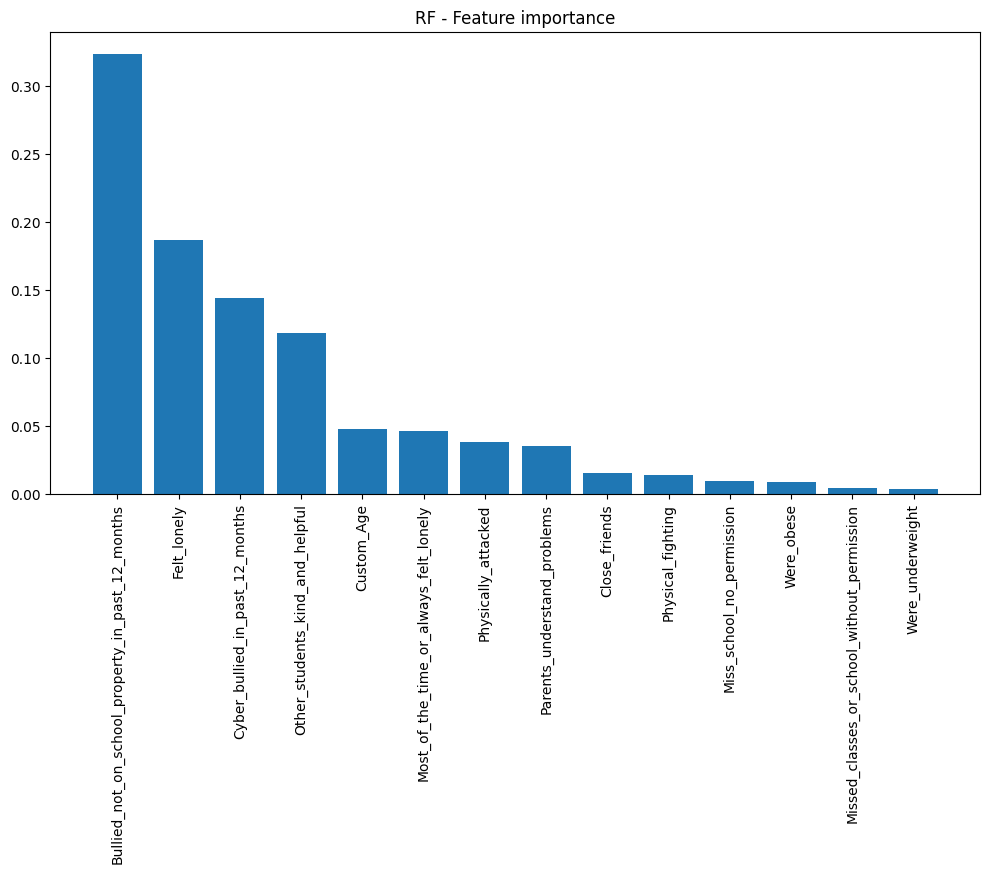

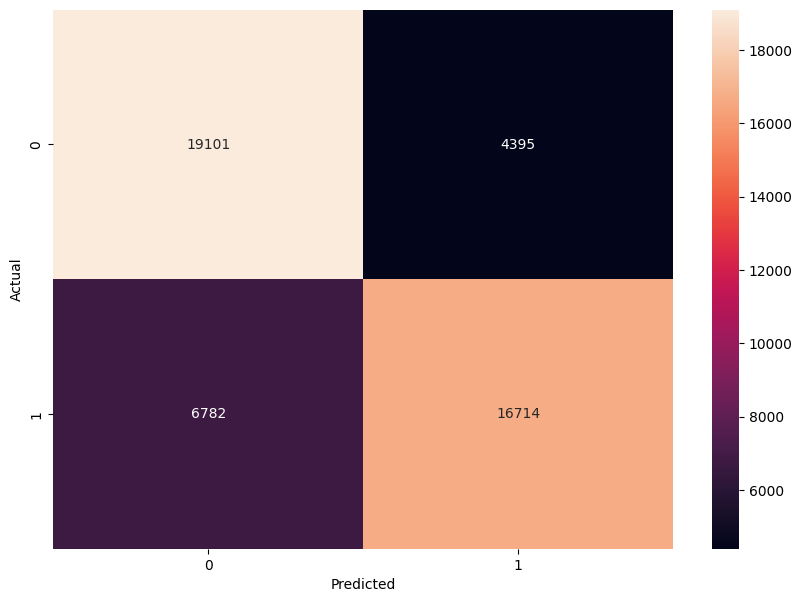

[I 2023-12-16 17:56:13,458] Trial 12 finished with value: 0.7113553177905666 and parameters: {'classifier': 'XGB', 'n_estimators': 195, 'xgb_learning_rate': 0.018299264365457014, 'xgb_max_depth': 6, 'xgb_colsample_bytree': 0.8784240152025138, 'xgb_subsample': 0.8131645181096497, 'xgb_min_child_weight': 5}. Best is trial 10 with value: 0.7156111078409622.


Mean Accuracy: 0.7621525167119312
Mean Precision: 0.7870864193304082
Mean Recall: 0.7113553177905666
Mean F1 Score: 0.7471973178936191


[I 2023-12-16 17:56:19,163] Trial 13 finished with value: 0.6924153622545314 and parameters: {'classifier': 'XGB', 'n_estimators': 407, 'xgb_learning_rate': 0.08287519170168187, 'xgb_max_depth': 4, 'xgb_colsample_bytree': 0.9642420483348001, 'xgb_subsample': 0.9131944506663733, 'xgb_min_child_weight': 6}. Best is trial 10 with value: 0.7156111078409622.


Mean Accuracy: 0.779326671044252
Mean Precision: 0.8198190510536646
Mean Recall: 0.6924153622545314
Mean F1 Score: 0.7499686801205179


[I 2023-12-16 17:56:24,808] Trial 14 finished with value: 0.7409349657917257 and parameters: {'classifier': 'XGB', 'n_estimators': 279, 'xgb_learning_rate': 0.19005360713237776, 'xgb_max_depth': 8, 'xgb_colsample_bytree': 0.7056119829553579, 'xgb_subsample': 0.6603499248368432, 'xgb_min_child_weight': 3}. Best is trial 14 with value: 0.7409349657917257.


Mean Accuracy: 0.7986278984776061
Mean Precision: 0.8346156564091692
Mean Recall: 0.7409349657917257
Mean F1 Score: 0.7785515197099788


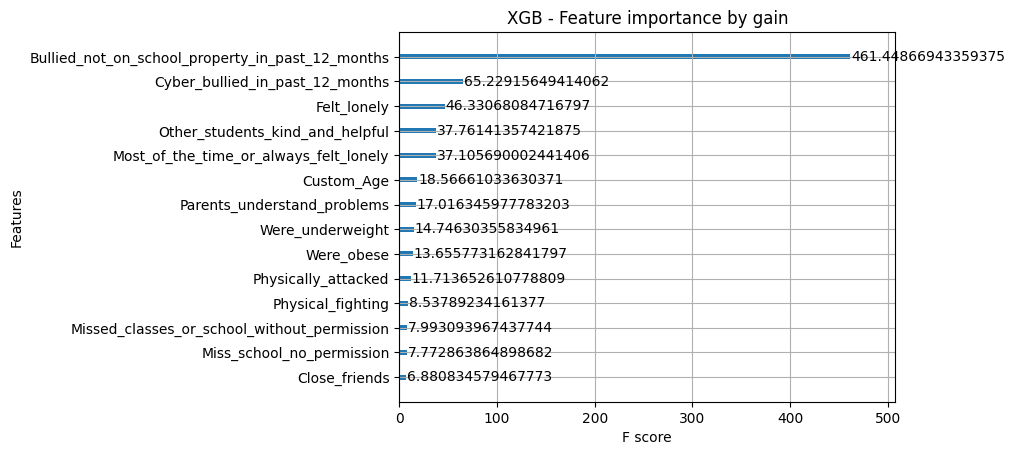

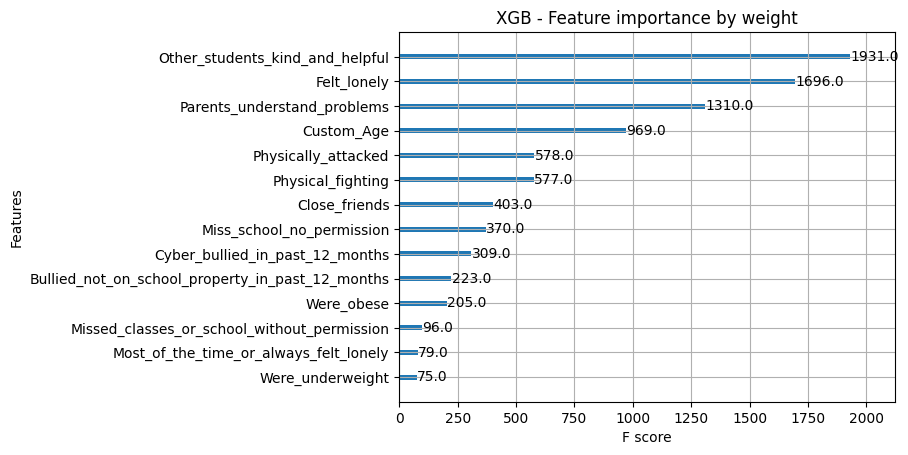

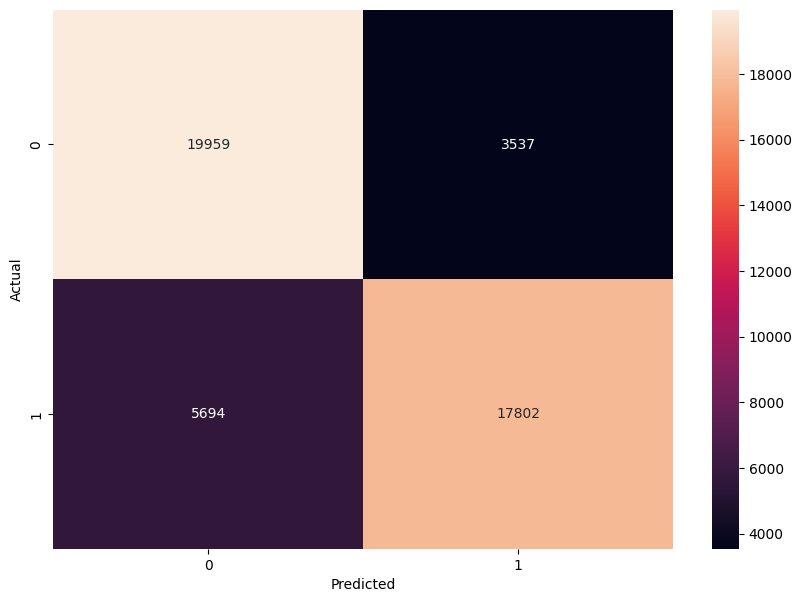

[I 2023-12-16 17:56:41,108] Trial 15 finished with value: 0.7576611954558009 and parameters: {'classifier': 'XGB', 'n_estimators': 601, 'xgb_learning_rate': 0.17886487366207796, 'xgb_max_depth': 8, 'xgb_colsample_bytree': 0.7306119912876481, 'xgb_subsample': 0.6076013728771676, 'xgb_min_child_weight': 3}. Best is trial 15 with value: 0.7576611954558009.


Mean Accuracy: 0.8035649765188759
Mean Precision: 0.8426261061746511
Mean Recall: 0.7576611954558009
Mean F1 Score: 0.786507437032749


[I 2023-12-16 17:56:55,802] Trial 16 finished with value: 0.757746374285158 and parameters: {'classifier': 'XGB', 'n_estimators': 591, 'xgb_learning_rate': 0.19831517146836486, 'xgb_max_depth': 8, 'xgb_colsample_bytree': 0.7029492895126016, 'xgb_subsample': 0.6114815734331156, 'xgb_min_child_weight': 3}. Best is trial 16 with value: 0.757746374285158.


Mean Accuracy: 0.8029478397825507
Mean Precision: 0.8391267463856245
Mean Recall: 0.757746374285158
Mean F1 Score: 0.7862430823807287


[I 2023-12-16 17:57:21,058] Trial 17 finished with value: 0.7578741425291937 and parameters: {'classifier': 'XGB', 'n_estimators': 694, 'xgb_learning_rate': 0.18238354326445516, 'xgb_max_depth': 8, 'xgb_colsample_bytree': 0.7025362369370228, 'xgb_subsample': 0.6152579226598955, 'xgb_min_child_weight': 3}. Best is trial 17 with value: 0.7578741425291937.


Mean Accuracy: 0.8030967940629129
Mean Precision: 0.8400724944331203
Mean Recall: 0.7578741425291937
Mean F1 Score: 0.7864523249596069


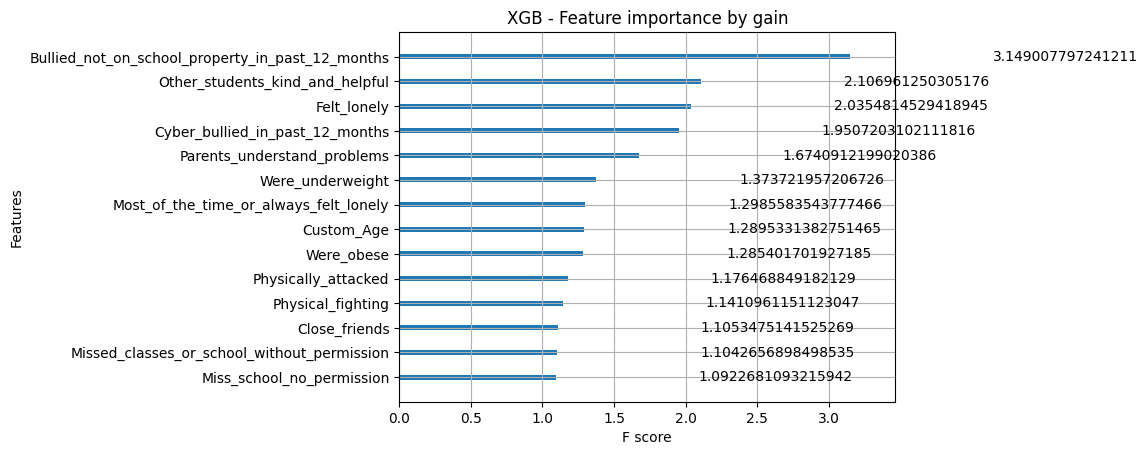

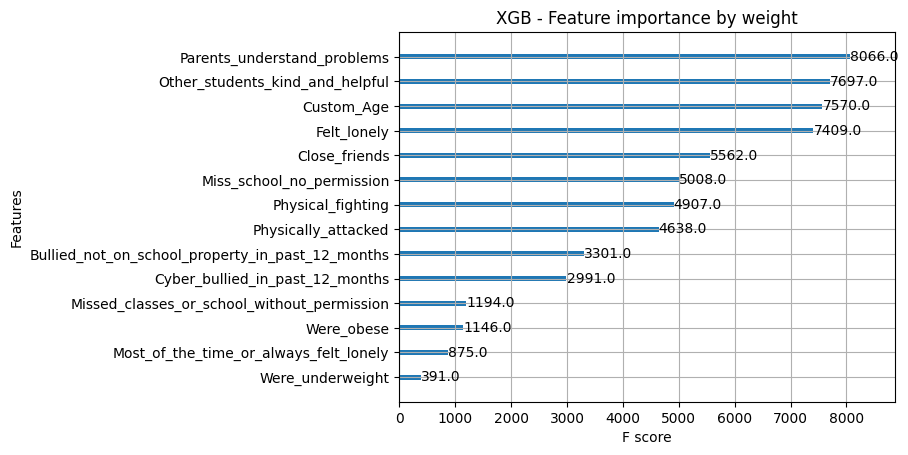

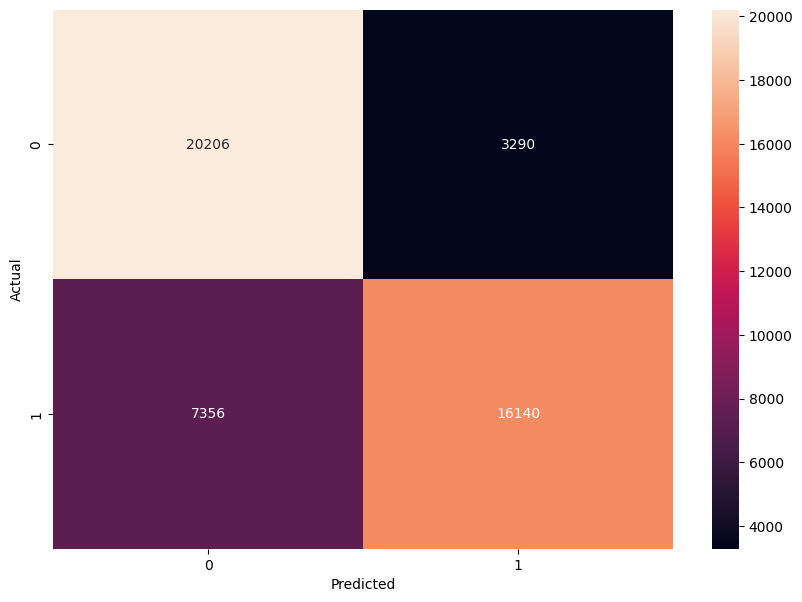

[I 2023-12-16 17:57:32,999] Trial 18 finished with value: 0.686925058749485 and parameters: {'classifier': 'XGB', 'n_estimators': 732, 'xgb_learning_rate': 0.198392021692109, 'xgb_max_depth': 2, 'xgb_colsample_bytree': 0.7630032367720899, 'xgb_subsample': 0.6745879593687297, 'xgb_min_child_weight': 8}. Best is trial 17 with value: 0.7578741425291937.


Mean Accuracy: 0.7734532869600012
Mean Precision: 0.8132957905405651
Mean Recall: 0.686925058749485
Mean F1 Score: 0.7435229289421248


[I 2023-12-16 17:58:02,884] Trial 19 finished with value: 0.7651520875876715 and parameters: {'classifier': 'XGB', 'n_estimators': 1000, 'xgb_learning_rate': 0.15946293699877712, 'xgb_max_depth': 8, 'xgb_colsample_bytree': 0.7790667002228749, 'xgb_subsample': 0.618971757085885, 'xgb_min_child_weight': 3}. Best is trial 19 with value: 0.7651520875876715.


Mean Accuracy: 0.8052248498224909
Mean Precision: 0.8442710700707712
Mean Recall: 0.7651520875876715
Mean F1 Score: 0.7901534307086813


[I 2023-12-16 17:58:23,273] Trial 20 finished with value: 0.7512347126821913 and parameters: {'classifier': 'XGB', 'n_estimators': 792, 'xgb_learning_rate': 0.14937301242915524, 'xgb_max_depth': 7, 'xgb_colsample_bytree': 0.7832903701640272, 'xgb_subsample': 0.7216438607615194, 'xgb_min_child_weight': 4}. Best is trial 19 with value: 0.7651520875876715.


Mean Accuracy: 0.8020114227942503
Mean Precision: 0.8390117541476649
Mean Recall: 0.7512347126821913
Mean F1 Score: 0.7840234007292729


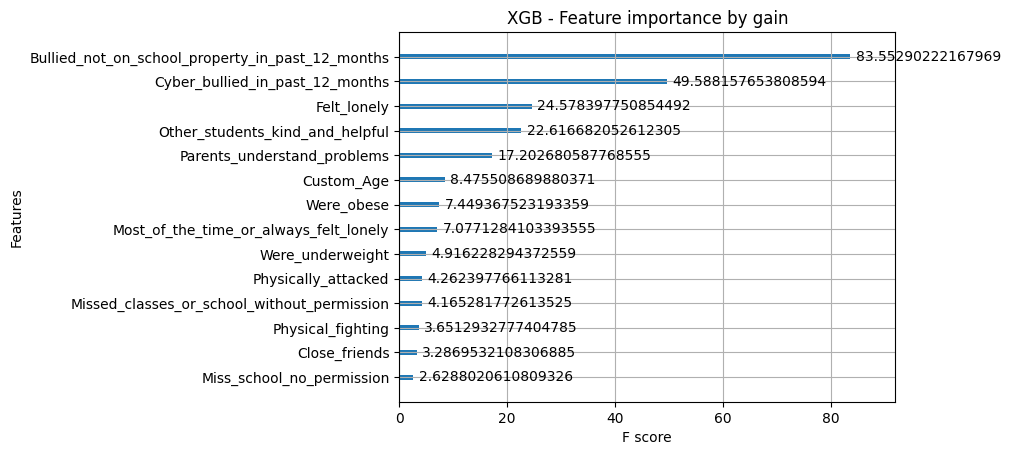

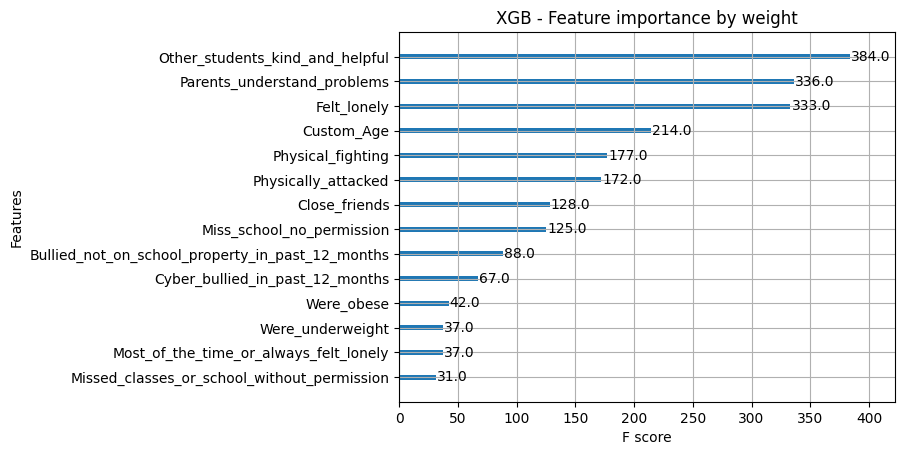

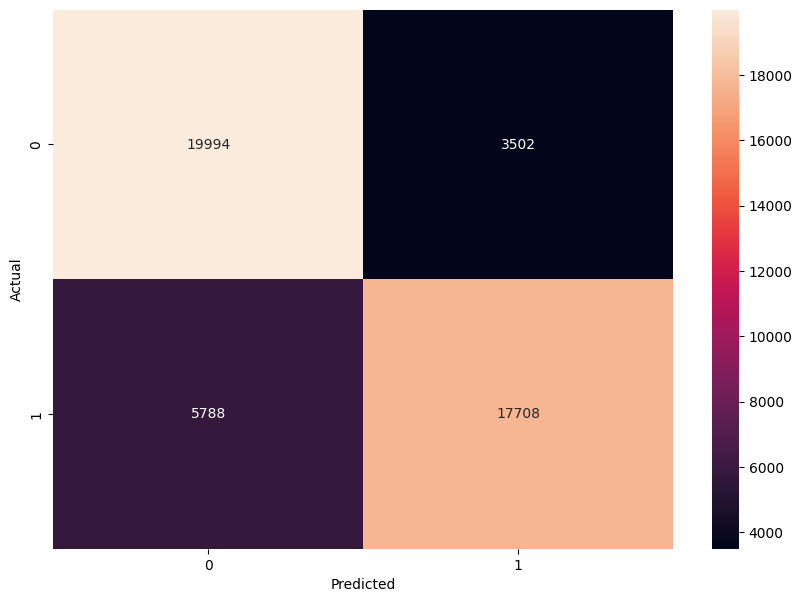

[I 2023-12-16 17:58:38,894] Trial 21 finished with value: 0.7536606611637605 and parameters: {'classifier': 'XGB', 'n_estimators': 577, 'xgb_learning_rate': 0.15976791497639203, 'xgb_max_depth': 8, 'xgb_colsample_bytree': 0.7004780894583306, 'xgb_subsample': 0.6005253626772463, 'xgb_min_child_weight': 3}. Best is trial 19 with value: 0.7651520875876715.


Mean Accuracy: 0.8023094355077236
Mean Precision: 0.839753200513555
Mean Recall: 0.7536606611637605
Mean F1 Score: 0.7847923236502818


[I 2023-12-16 17:59:00,730] Trial 22 finished with value: 0.7641731468442811 and parameters: {'classifier': 'XGB', 'n_estimators': 992, 'xgb_learning_rate': 0.156406517294378, 'xgb_max_depth': 8, 'xgb_colsample_bytree': 0.7535156978404726, 'xgb_subsample': 0.6064629465932972, 'xgb_min_child_weight': 3}. Best is trial 19 with value: 0.7651520875876715.


Mean Accuracy: 0.8055440847906624
Mean Precision: 0.8432730996699391
Mean Recall: 0.7641731468442811
Mean F1 Score: 0.7898677821520306


[I 2023-12-16 17:59:18,659] Trial 23 finished with value: 0.7524265280525961 and parameters: {'classifier': 'XGB', 'n_estimators': 994, 'xgb_learning_rate': 0.1441130435985817, 'xgb_max_depth': 7, 'xgb_colsample_bytree': 0.7762353964598916, 'xgb_subsample': 0.6781003564373931, 'xgb_min_child_weight': 4}. Best is trial 19 with value: 0.7651520875876715.


Mean Accuracy: 0.8014369230234882
Mean Precision: 0.8368805686953094
Mean Recall: 0.7524265280525961
Mean F1 Score: 0.7836422385699063


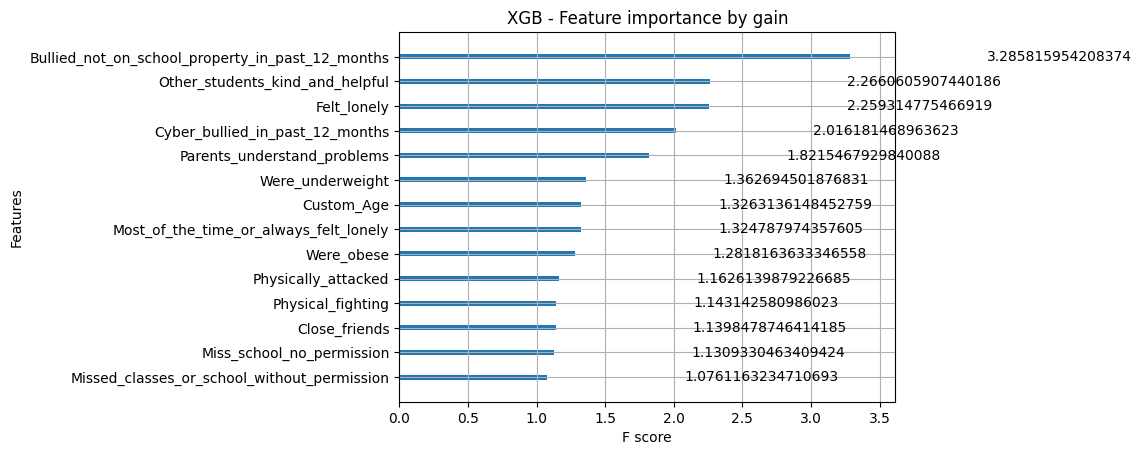

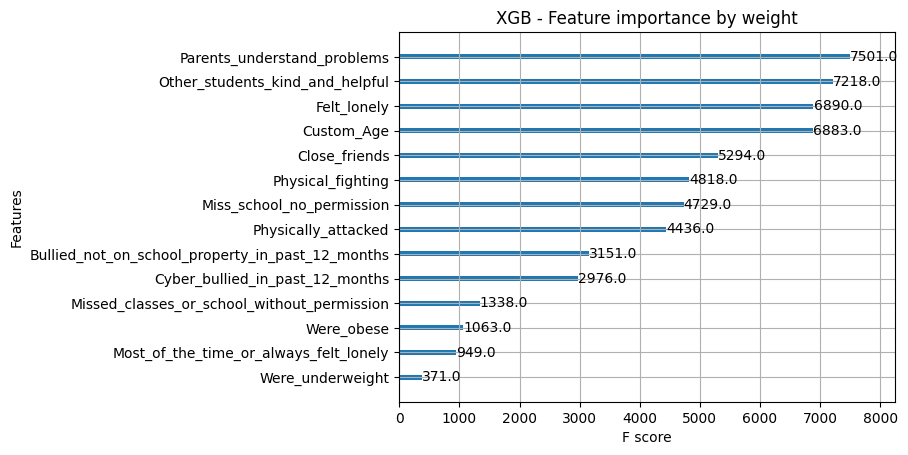

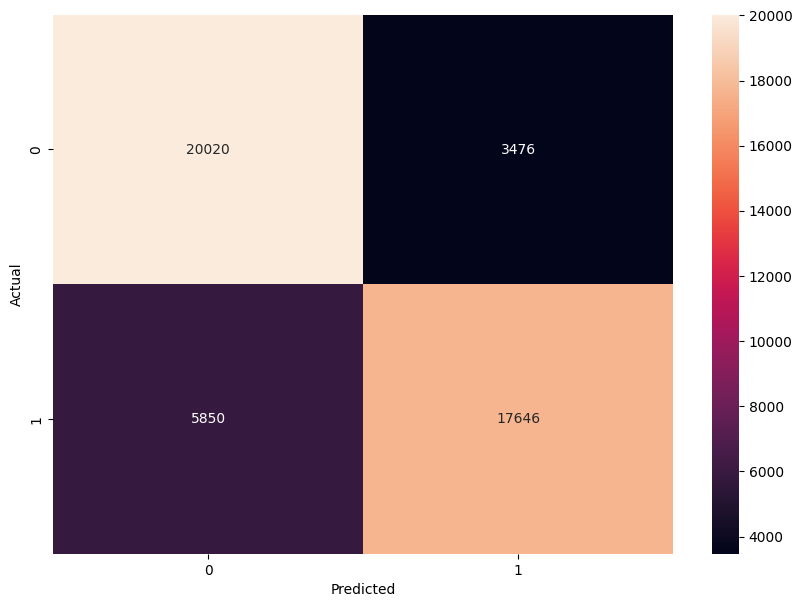

[I 2023-12-16 17:59:40,514] Trial 24 finished with value: 0.7510219195573526 and parameters: {'classifier': 'XGB', 'n_estimators': 992, 'xgb_learning_rate': 0.1303680236281503, 'xgb_max_depth': 7, 'xgb_colsample_bytree': 0.765245350828033, 'xgb_subsample': 0.7268259270861036, 'xgb_min_child_weight': 4}. Best is trial 19 with value: 0.7651520875876715.


Mean Accuracy: 0.801543330905895
Mean Precision: 0.8393314506634747
Mean Recall: 0.7510219195573526
Mean F1 Score: 0.7835011532330707


[I 2023-12-16 18:00:14,570] Trial 25 finished with value: 0.7555759260684709 and parameters: {'classifier': 'XGB', 'n_estimators': 893, 'xgb_learning_rate': 0.16949813913380934, 'xgb_max_depth': 7, 'xgb_colsample_bytree': 0.8110149712405672, 'xgb_subsample': 0.6391286552198557, 'xgb_min_child_weight': 4}. Best is trial 19 with value: 0.7651520875876715.


Mean Accuracy: 0.8023306396489002
Mean Precision: 0.8394351672877269
Mean Recall: 0.7555759260684709
Mean F1 Score: 0.7853955801445296


[I 2023-12-16 18:00:35,400] Trial 26 finished with value: 0.6941180151503489 and parameters: {'classifier': 'XGB', 'n_estimators': 803, 'xgb_learning_rate': 0.1704746146805922, 'xgb_max_depth': 3, 'xgb_colsample_bytree': 0.7384975254881628, 'xgb_subsample': 0.6007056209045037, 'xgb_min_child_weight': 7}. Best is trial 19 with value: 0.7651520875876715.


Mean Accuracy: 0.7779009263277568
Mean Precision: 0.8173345856772074
Mean Recall: 0.6941180151503489
Mean F1 Score: 0.7492530458939568


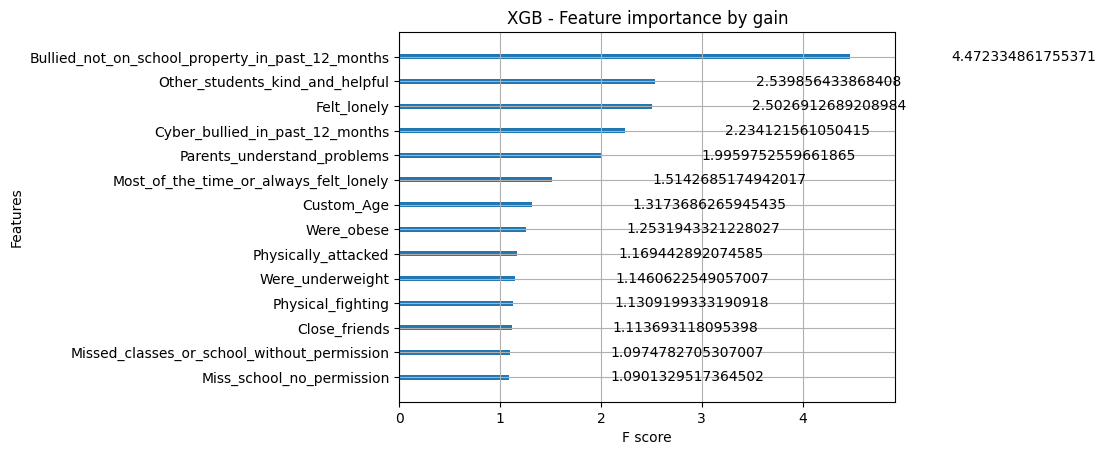

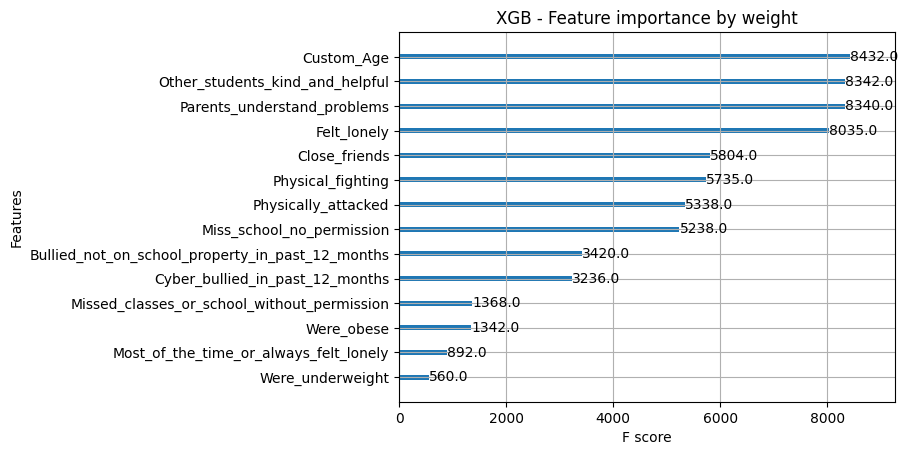

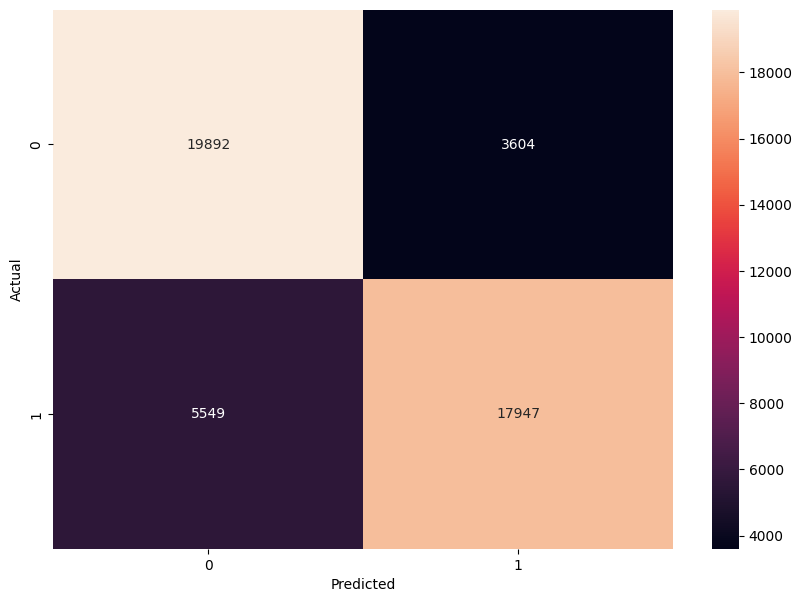

[I 2023-12-16 18:01:20,621] Trial 27 finished with value: 0.7638326398101905 and parameters: {'classifier': 'XGB', 'n_estimators': 998, 'xgb_learning_rate': 0.12635186540216087, 'xgb_max_depth': 8, 'xgb_colsample_bytree': 0.8083871026988237, 'xgb_subsample': 0.6576192754311776, 'xgb_min_child_weight': 3}. Best is trial 19 with value: 0.7651520875876715.


Mean Accuracy: 0.8052247615190733
Mean Precision: 0.8421392460305508
Mean Recall: 0.7638326398101905
Mean F1 Score: 0.7898625812698521


[I 2023-12-16 18:01:45,968] Trial 28 finished with value: 0.7184204606684084 and parameters: {'classifier': 'XGB', 'n_estimators': 943, 'xgb_learning_rate': 0.1253211339584285, 'xgb_max_depth': 5, 'xgb_colsample_bytree': 0.81758401797138, 'xgb_subsample': 0.7008282157896821, 'xgb_min_child_weight': 4}. Best is trial 19 with value: 0.7651520875876715.


Mean Accuracy: 0.790498814911531
Mean Precision: 0.8295902581665784
Mean Recall: 0.7184204606684084
Mean F1 Score: 0.766030937872414


[I 2023-12-16 18:03:22,997] Trial 29 finished with value: 0.6623678827093133 and parameters: {'classifier': 'RF', 'rf_max_depth': 5, 'rf_min_samples_split': 14}. Best is trial 19 with value: 0.7651520875876715.


Mean Accuracy: 0.7087377092114571
Mean Precision: 0.7082627280459829
Mean Recall: 0.6623678827093133
Mean F1 Score: 0.6945736717769762


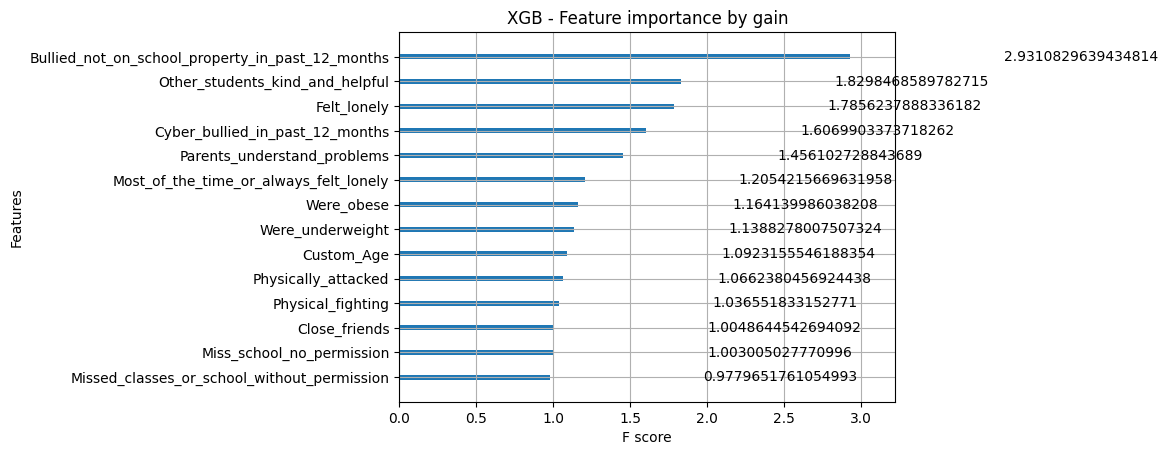

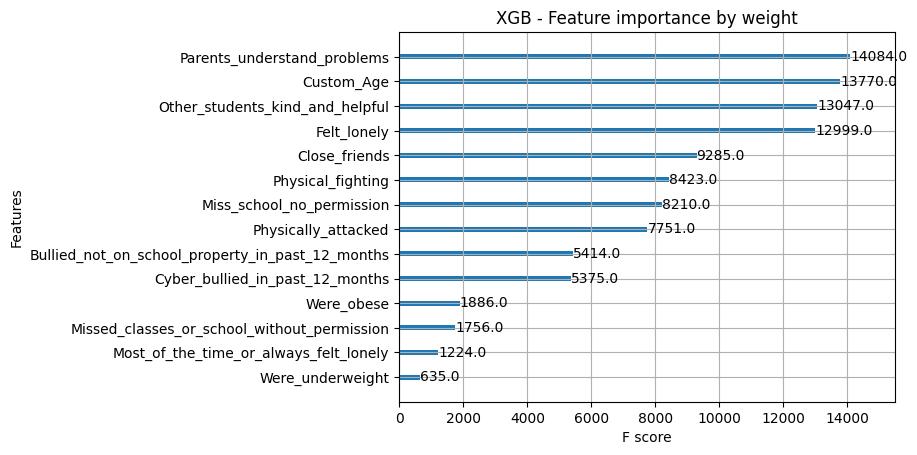

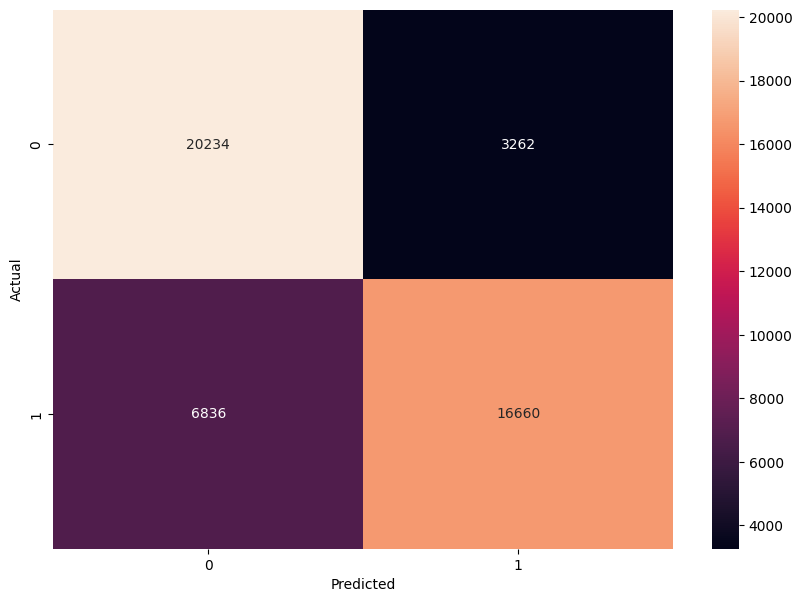

[I 2023-12-16 18:03:44,026] Trial 30 finished with value: 0.7090563315870737 and parameters: {'classifier': 'LGBM', 'n_estimators': 820, 'lgbm_learning_rate': 0.0104506826710358, 'lgbm_max_depth': 8, 'lgbm_num_leaves': 34, 'lgbm_subsample': 0.8546555973089801}. Best is trial 19 with value: 0.7651520875876715.


Mean Accuracy: 0.7851146974223394
Mean Precision: 0.8223046575987752
Mean Recall: 0.7090563315870737
Mean F1 Score: 0.7599642871470055


[I 2023-12-16 18:10:26,188] Trial 31 finished with value: 0.7652370219105015 and parameters: {'classifier': 'XGB', 'n_estimators': 999, 'xgb_learning_rate': 0.16204648564355817, 'xgb_max_depth': 8, 'xgb_colsample_bytree': 0.7398189898945873, 'xgb_subsample': 0.6436975158141908, 'xgb_min_child_weight': 3}. Best is trial 31 with value: 0.7652370219105015.


Mean Accuracy: 0.8057568303655801
Mean Precision: 0.8430549329525456
Mean Recall: 0.7652370219105015
Mean F1 Score: 0.7904442524658479


[I 2023-12-16 18:10:46,361] Trial 32 finished with value: 0.7654073976808103 and parameters: {'classifier': 'XGB', 'n_estimators': 940, 'xgb_learning_rate': 0.1536216299063823, 'xgb_max_depth': 8, 'xgb_colsample_bytree': 0.8011142165601863, 'xgb_subsample': 0.65026812474713, 'xgb_min_child_weight': 3}. Best is trial 32 with value: 0.7654073976808103.


Mean Accuracy: 0.8061823577424583
Mean Precision: 0.8428625196339703
Mean Recall: 0.7654073976808103
Mean F1 Score: 0.7910089276675705


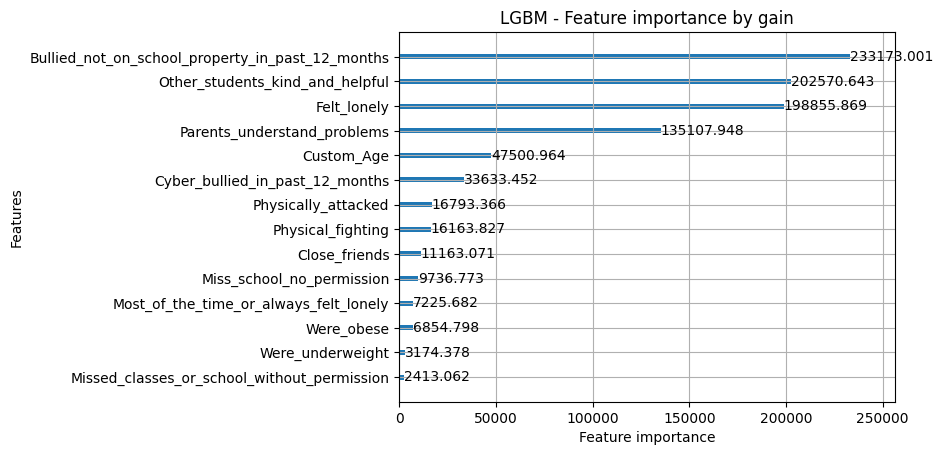

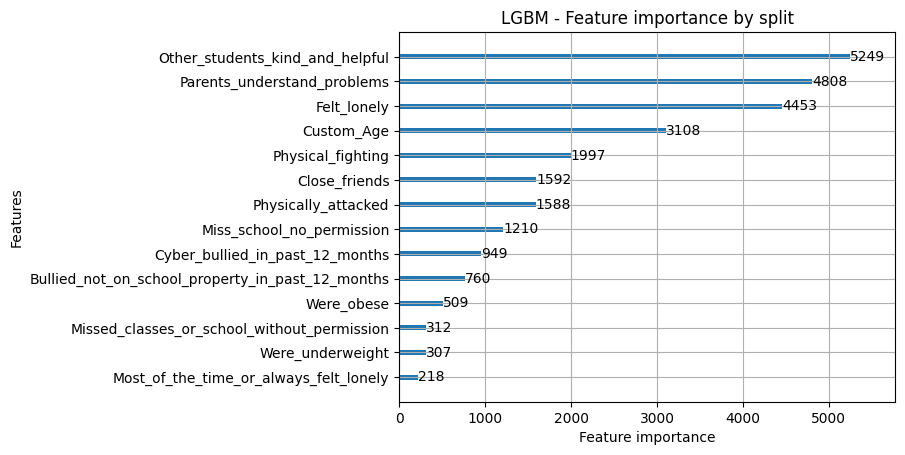

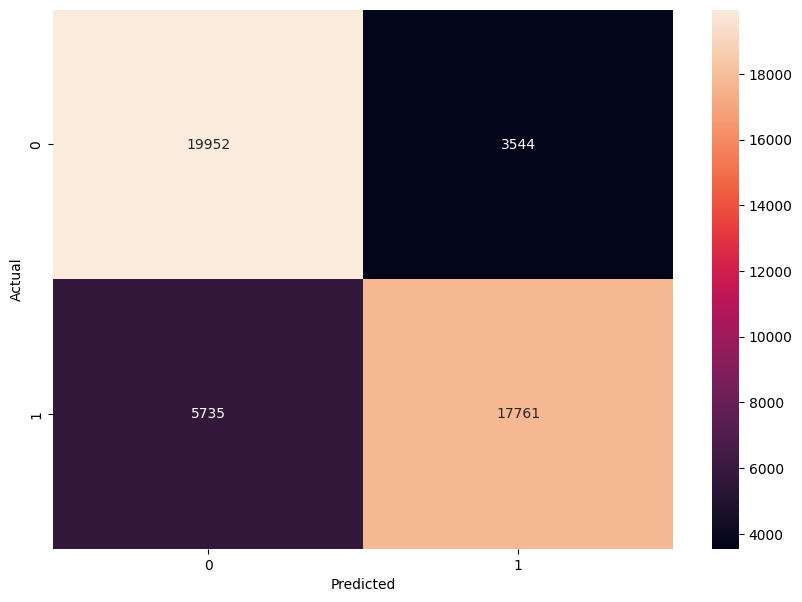

[I 2023-12-16 18:11:02,543] Trial 33 finished with value: 0.7559164874373453 and parameters: {'classifier': 'XGB', 'n_estimators': 919, 'xgb_learning_rate': 0.1585622488101545, 'xgb_max_depth': 7, 'xgb_colsample_bytree': 0.7469034919534268, 'xgb_subsample': 0.6442635989028723, 'xgb_min_child_weight': 3}. Best is trial 32 with value: 0.7654073976808103.


Mean Accuracy: 0.8025434667346648
Mean Precision: 0.8389058232559319
Mean Recall: 0.7559164874373453
Mean F1 Score: 0.7856703299832744


[I 2023-12-16 18:11:23,904] Trial 34 finished with value: 0.7588105663042839 and parameters: {'classifier': 'XGB', 'n_estimators': 945, 'xgb_learning_rate': 0.14546632437563012, 'xgb_max_depth': 8, 'xgb_colsample_bytree': 0.778965140394084, 'xgb_subsample': 0.6406837672632139, 'xgb_min_child_weight': 4}. Best is trial 32 with value: 0.7654073976808103.


Mean Accuracy: 0.8031819638412901
Mean Precision: 0.8412814580384427
Mean Recall: 0.7588105663042839
Mean F1 Score: 0.786639359215551


[I 2023-12-16 18:11:41,106] Trial 35 finished with value: 0.7631941336545123 and parameters: {'classifier': 'LGBM', 'n_estimators': 843, 'lgbm_learning_rate': 0.1308214382126605, 'lgbm_max_depth': 8, 'lgbm_num_leaves': 178, 'lgbm_subsample': 0.8158845185725171}. Best is trial 32 with value: 0.7654073976808103.


Mean Accuracy: 0.8085446394493345
Mean Precision: 0.8493575544762616
Mean Recall: 0.7631941336545123
Mean F1 Score: 0.7913479377792783


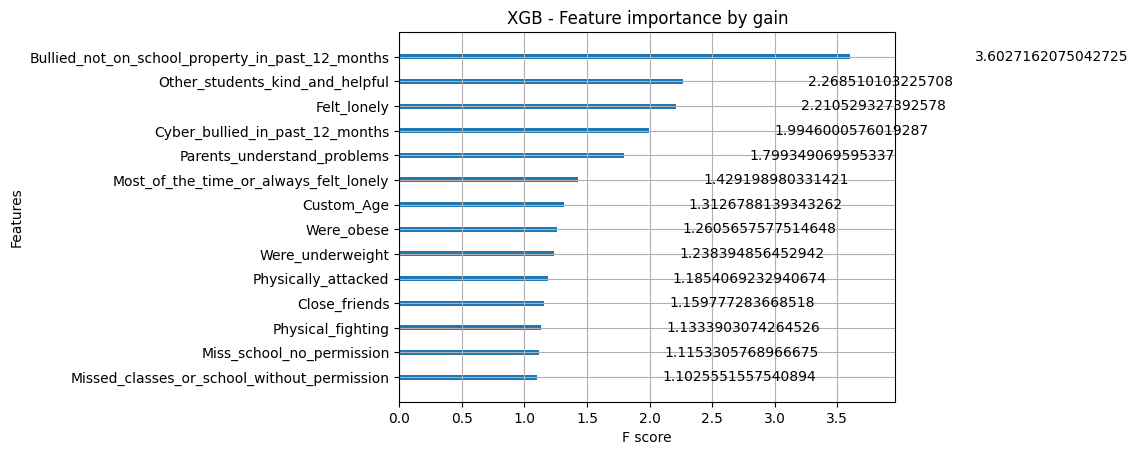

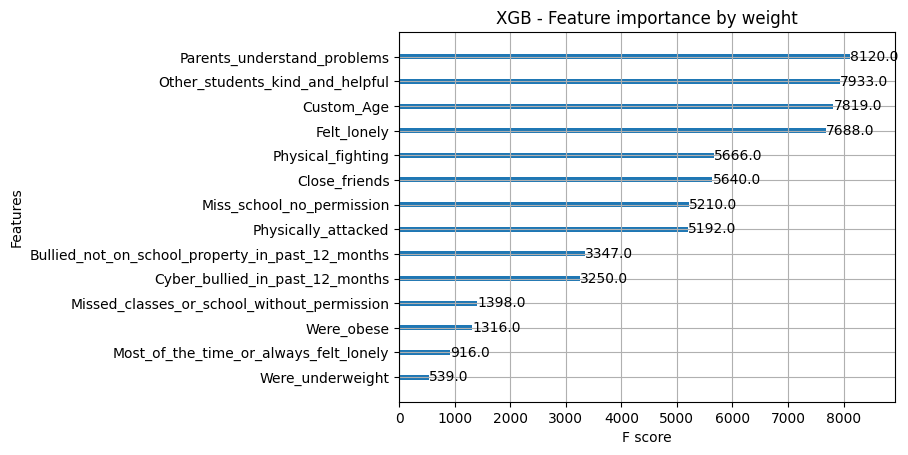

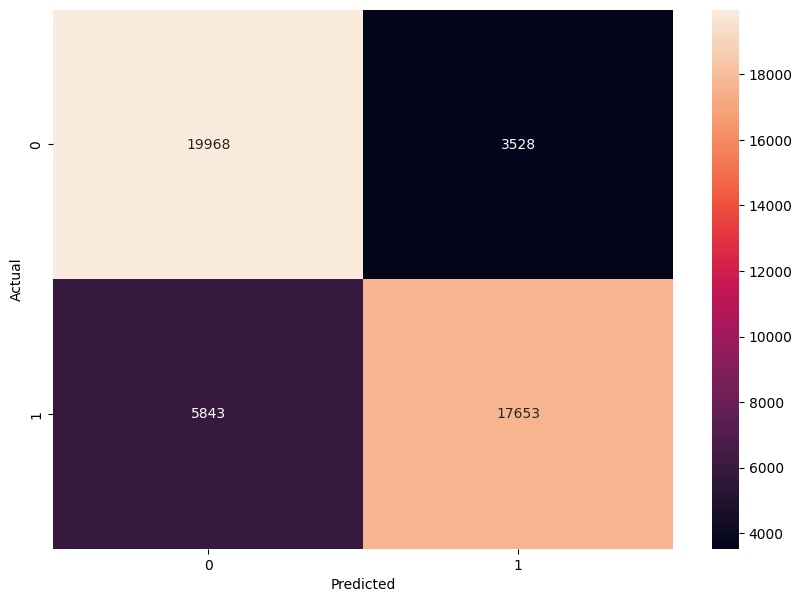

[I 2023-12-16 18:12:01,311] Trial 36 finished with value: 0.7513199911253186 and parameters: {'classifier': 'XGB', 'n_estimators': 741, 'xgb_learning_rate': 0.1702835459778552, 'xgb_max_depth': 7, 'xgb_colsample_bytree': 0.7315486427401003, 'xgb_subsample': 0.6989326077164835, 'xgb_min_child_weight': 3}. Best is trial 32 with value: 0.7654073976808103.


Mean Accuracy: 0.8005856305297611
Mean Precision: 0.8349650226769282
Mean Recall: 0.7513199911253186
Mean F1 Score: 0.7830318285721063


[I 2023-12-16 18:12:42,098] Trial 37 finished with value: 0.6441947086976405 and parameters: {'classifier': 'RF', 'rf_max_depth': 2, 'rf_min_samples_split': 15}. Best is trial 32 with value: 0.7654073976808103.


Mean Accuracy: 0.6916918937077725
Mean Precision: 0.6871286234872731
Mean Recall: 0.6441947086976405
Mean F1 Score: 0.6762055066521405


[I 2023-12-16 18:12:53,499] Trial 38 finished with value: 0.7249746211280808 and parameters: {'classifier': 'LGBM', 'n_estimators': 950, 'lgbm_learning_rate': 0.09523180812005533, 'lgbm_max_depth': 6, 'lgbm_num_leaves': 169, 'lgbm_subsample': 0.9228157325980137}. Best is trial 32 with value: 0.7654073976808103.


Mean Accuracy: 0.7951804832420378
Mean Precision: 0.8346211512872979
Mean Recall: 0.7249746211280808
Mean F1 Score: 0.7709563521464797


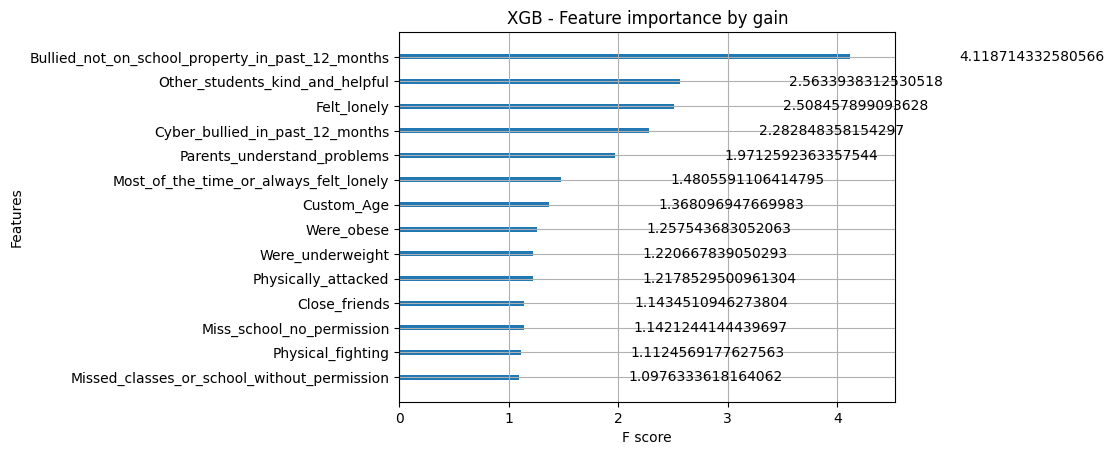

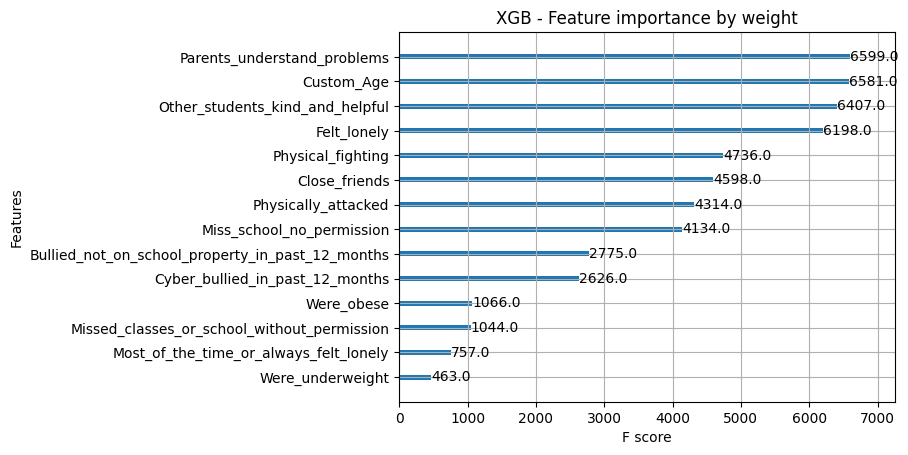

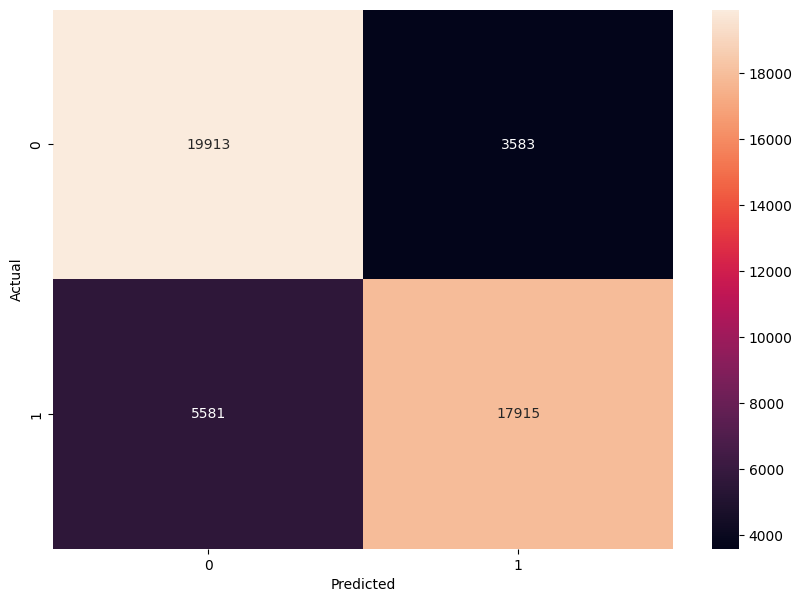

[I 2023-12-16 18:13:16,529] Trial 39 finished with value: 0.7624707927897743 and parameters: {'classifier': 'XGB', 'n_estimators': 889, 'xgb_learning_rate': 0.15858266199868024, 'xgb_max_depth': 8, 'xgb_colsample_bytree': 0.7492238666393294, 'xgb_subsample': 0.6352740757865387, 'xgb_min_child_weight': 3}. Best is trial 32 with value: 0.7654073976808103.


Mean Accuracy: 0.8049907076502301
Mean Precision: 0.8427713053763093
Mean Recall: 0.7624707927897743
Mean F1 Score: 0.789251723739716


[I 2023-12-16 18:14:11,381] Trial 40 finished with value: 0.6706672673678872 and parameters: {'classifier': 'RF', 'rf_max_depth': 6, 'rf_min_samples_split': 10}. Best is trial 32 with value: 0.7654073976808103.


Mean Accuracy: 0.7178033116543915
Mean Precision: 0.7208124128106908
Mean Recall: 0.6706672673678872
Mean F1 Score: 0.7038069896512671


[I 2023-12-16 18:14:30,616] Trial 41 finished with value: 0.7656628436109085 and parameters: {'classifier': 'XGB', 'n_estimators': 993, 'xgb_learning_rate': 0.13808337775257512, 'xgb_max_depth': 8, 'xgb_colsample_bytree': 0.8021908502686967, 'xgb_subsample': 0.6591890676056993, 'xgb_min_child_weight': 3}. Best is trial 41 with value: 0.7656628436109085.


Mean Accuracy: 0.8067144696085788
Mean Precision: 0.8447039976127192
Mean Recall: 0.7656628436109085
Mean F1 Score: 0.791320469679526


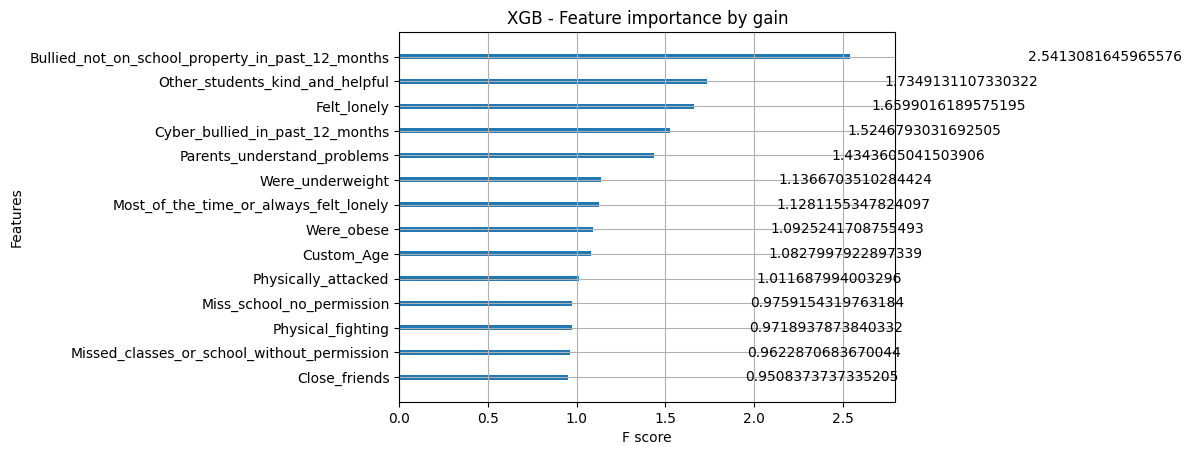

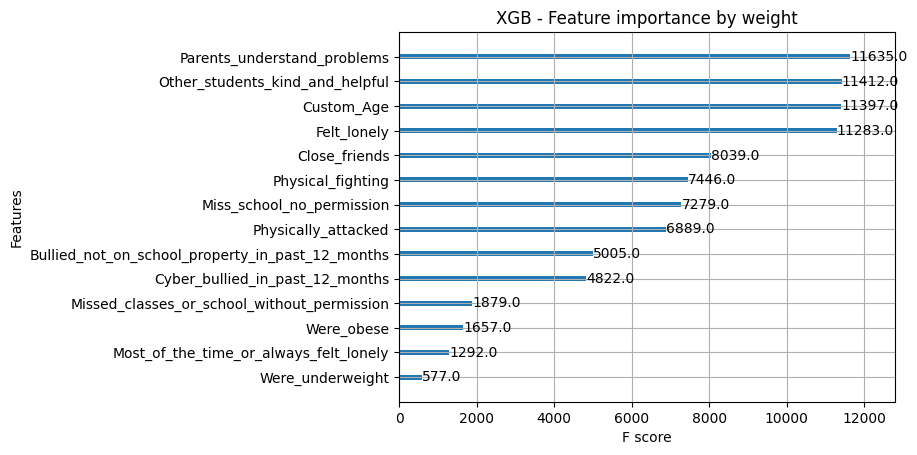

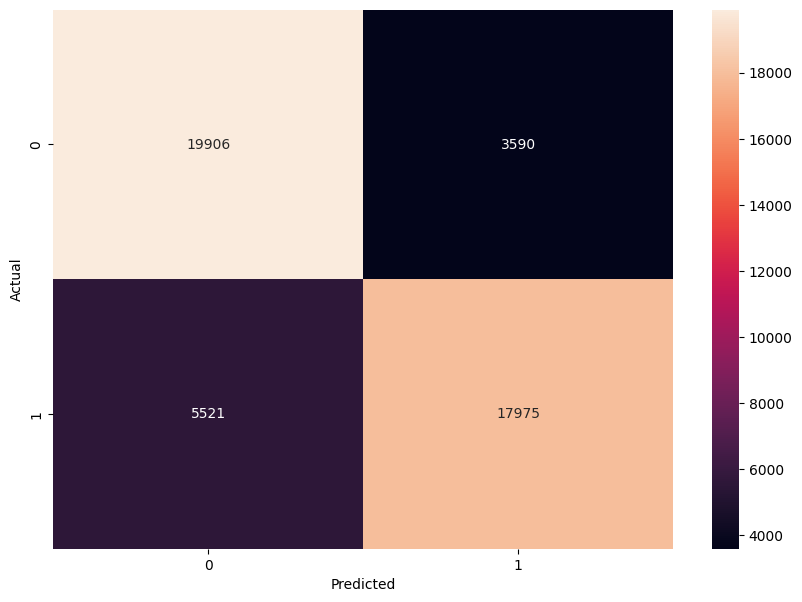

[I 2023-12-16 18:14:55,041] Trial 42 finished with value: 0.7650242921762439 and parameters: {'classifier': 'XGB', 'n_estimators': 996, 'xgb_learning_rate': 0.1364279413710636, 'xgb_max_depth': 8, 'xgb_colsample_bytree': 0.7937850607019609, 'xgb_subsample': 0.6372800083093365, 'xgb_min_child_weight': 3}. Best is trial 41 with value: 0.7656628436109085.


Mean Accuracy: 0.8061186049391361
Mean Precision: 0.8426916627982781
Mean Recall: 0.7650242921762439
Mean F1 Score: 0.7906762433248254


[I 2023-12-16 18:15:13,487] Trial 43 finished with value: 0.7513626077073892 and parameters: {'classifier': 'XGB', 'n_estimators': 935, 'xgb_learning_rate': 0.13950101199437762, 'xgb_max_depth': 7, 'xgb_colsample_bytree': 0.7945237549997419, 'xgb_subsample': 0.6720669861711948, 'xgb_min_child_weight': 4}. Best is trial 41 with value: 0.7656628436109085.


Mean Accuracy: 0.8012453521552747
Mean Precision: 0.8381578051128432
Mean Recall: 0.7513626077073892
Mean F1 Score: 0.7832947452919108


[I 2023-12-16 18:15:33,037] Trial 44 finished with value: 0.7611087012628309 and parameters: {'classifier': 'XGB', 'n_estimators': 864, 'xgb_learning_rate': 0.1353745779638752, 'xgb_max_depth': 8, 'xgb_colsample_bytree': 0.8282243090630981, 'xgb_subsample': 0.6355546300977943, 'xgb_min_child_weight': 3}. Best is trial 41 with value: 0.7656628436109085.


Mean Accuracy: 0.8050332495198049
Mean Precision: 0.841783034040831
Mean Recall: 0.7611087012628309
Mean F1 Score: 0.7888174248810683


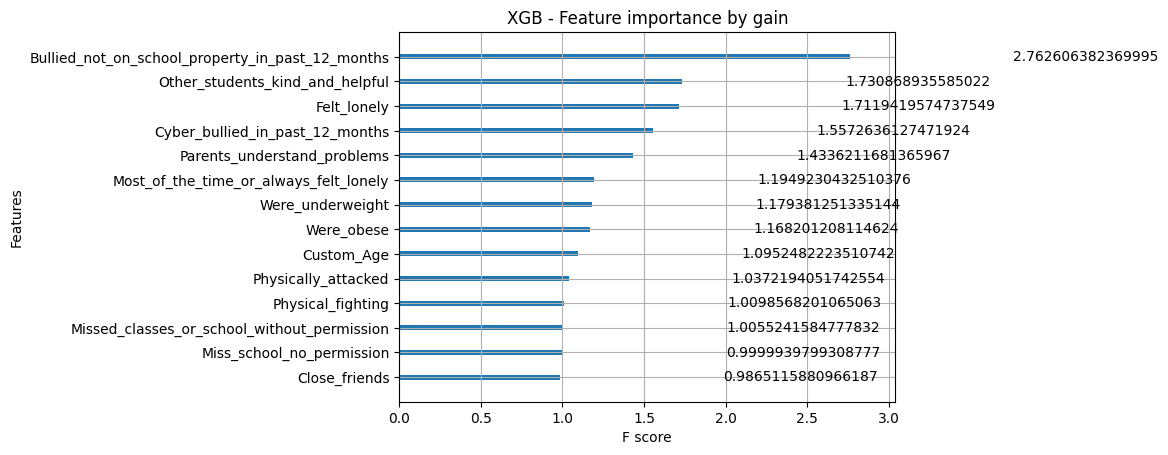

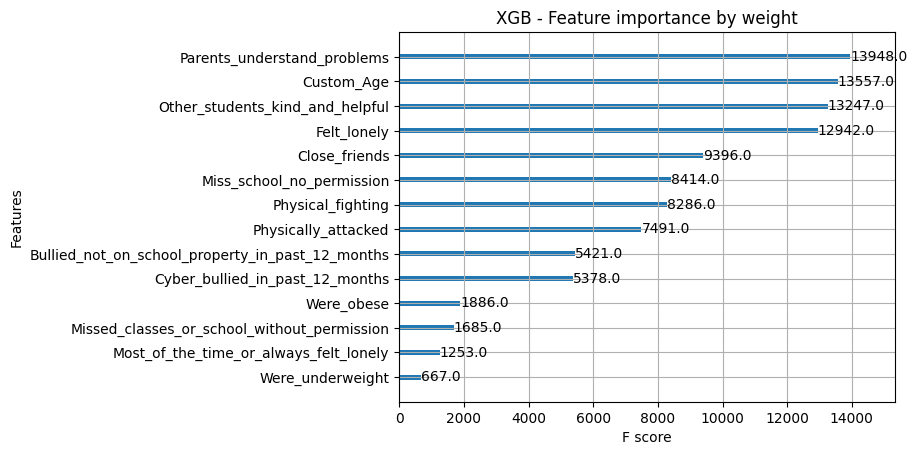

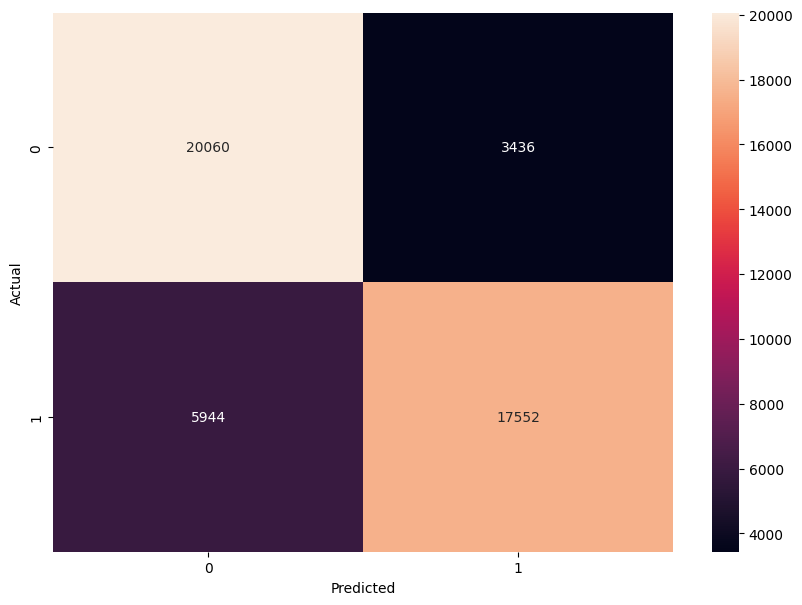

[I 2023-12-16 18:15:53,335] Trial 45 finished with value: 0.7470212765957447 and parameters: {'classifier': 'XGB', 'n_estimators': 949, 'xgb_learning_rate': 0.1115601260870786, 'xgb_max_depth': 7, 'xgb_colsample_bytree': 0.7956047059499963, 'xgb_subsample': 0.6951735698324943, 'xgb_min_child_weight': 4}. Best is trial 41 with value: 0.7656628436109085.


Mean Accuracy: 0.8003941592859161
Mean Precision: 0.8376696197993585
Mean Recall: 0.7470212765957447
Mean F1 Score: 0.7816586476088636


[I 2023-12-16 18:15:59,301] Trial 46 finished with value: 0.7033109353280236 and parameters: {'classifier': 'LGBM', 'n_estimators': 503, 'lgbm_learning_rate': 0.023634939311460643, 'lgbm_max_depth': 6, 'lgbm_num_leaves': 255, 'lgbm_subsample': 0.7548833869566541}. Best is trial 41 with value: 0.7656628436109085.


Mean Accuracy: 0.7849233575015259
Mean Precision: 0.8234000094614782
Mean Recall: 0.7033109353280236
Mean F1 Score: 0.757368625615104


[I 2023-12-16 18:16:13,409] Trial 47 finished with value: 0.7205484824747683 and parameters: {'classifier': 'XGB', 'n_estimators': 871, 'xgb_learning_rate': 0.1547891254669918, 'xgb_max_depth': 5, 'xgb_colsample_bytree': 0.8290125248306781, 'xgb_subsample': 0.6558185754341092, 'xgb_min_child_weight': 6}. Best is trial 41 with value: 0.7656628436109085.


Mean Accuracy: 0.789966777763687
Mean Precision: 0.8274429185188413
Mean Recall: 0.7205484824747683
Mean F1 Score: 0.7664856909906614


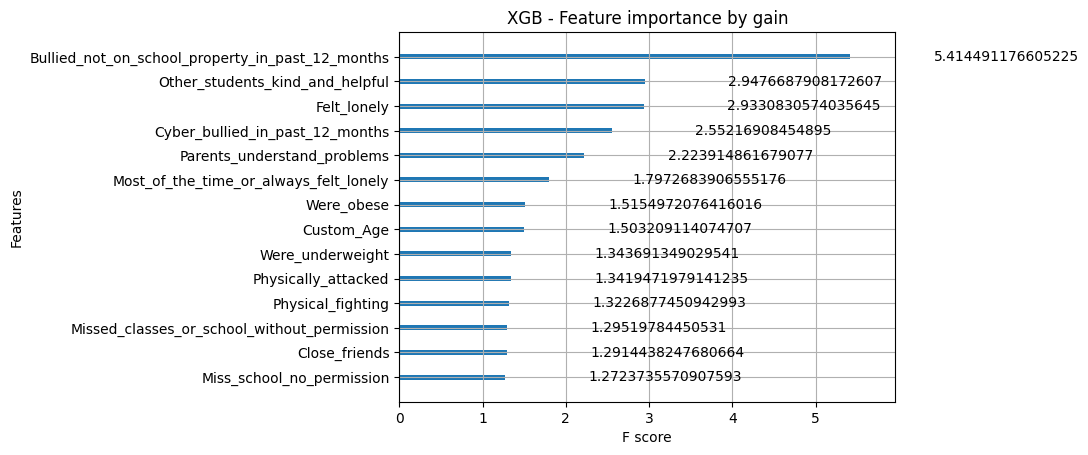

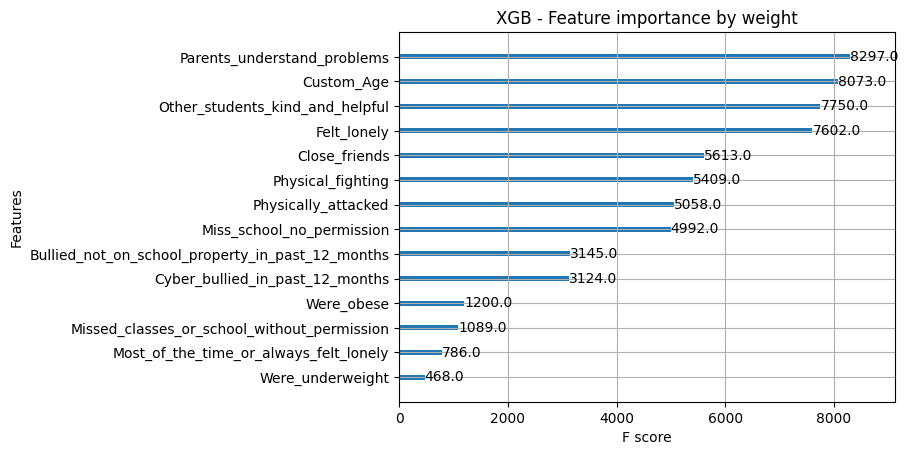

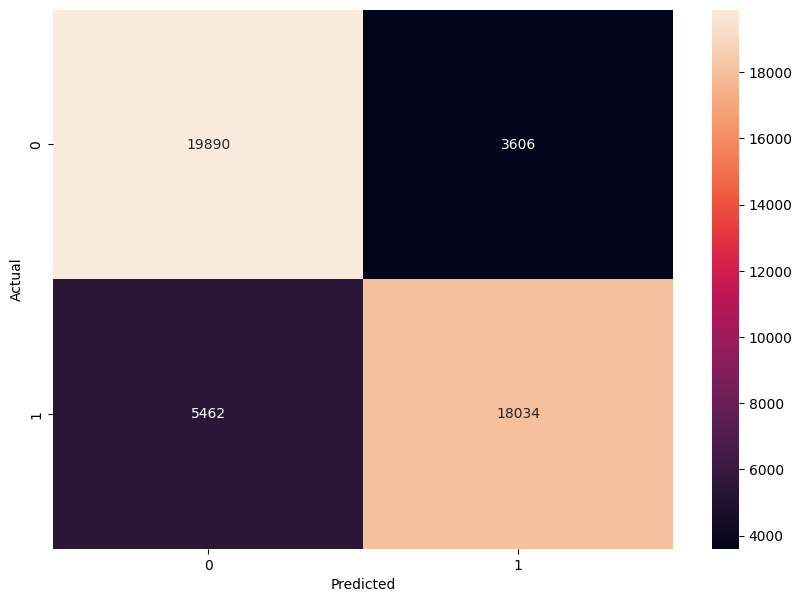

[I 2023-12-16 18:16:34,297] Trial 48 finished with value: 0.7675353742081837 and parameters: {'classifier': 'XGB', 'n_estimators': 908, 'xgb_learning_rate': 0.14333059365268128, 'xgb_max_depth': 8, 'xgb_colsample_bytree': 0.794046553801039, 'xgb_subsample': 0.7327894703367749, 'xgb_min_child_weight': 3}. Best is trial 48 with value: 0.7675353742081837.


Mean Accuracy: 0.8070336140091425
Mean Precision: 0.8446600349993842
Mean Recall: 0.7675353742081837
Mean F1 Score: 0.7922136176108775


[I 2023-12-16 18:17:32,995] Trial 49 finished with value: 0.6694329893639661 and parameters: {'classifier': 'RF', 'rf_max_depth': 6, 'rf_min_samples_split': 12}. Best is trial 48 with value: 0.7675353742081837.


Mean Accuracy: 0.7175904868328169
Mean Precision: 0.720803942003547
Mean Recall: 0.6694329893639661
Mean F1 Score: 0.7032738525733523


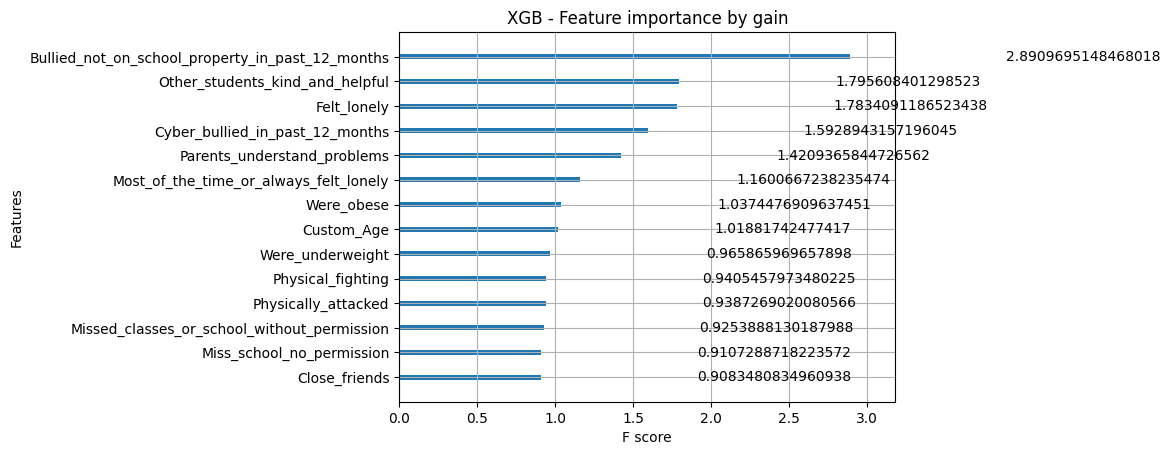

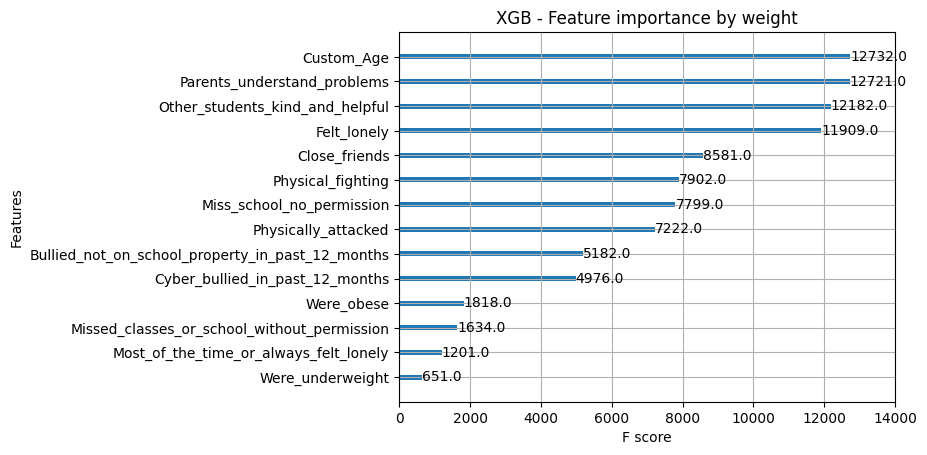

In [23]:
classifier_study = optuna.create_study(direction='maximize')
classifier_study.optimize(objective, n_trials=50)

In [24]:
transformed_train_df

Bullied_on_school_property_in_past_12_months  \
0                                                 0   
1                                                 0   
2                                                 0   
3                                                 0   
4                                                 0   
...                                             ...   
32933                                             0   
32934                                             0   
32935                                             0   
32936                                             0   
32937                                             0   

       Bullied_not_on_school_property_in_past_12_months  \
0                                                     0   
1                                                     0   
2                                                     0   
3                                                     0   
4                                                     0   
...                                                 ...   
32933                                                 1   
32934                                                 0   
32935                                                 0   
32936                                                 1   
32937                                                 1   

       Cyber_bullied_in_past_12_months  Custom_Age  Physically_attacked  \
0                                    0          14                    0   
1                                    0          13                    0   
2                                    0          15                    0   
3                                    1          13                    0   
4                                    0          14                    0   
...                                ...         ...                  ...   
32933                                0          16                    0   
32934                                0          16                    0   
32935                                1          15                    7   
32936                                0          16                    0   
32937                                1          16                    0   

       Physical_fighting  Felt_lonely  Close_friends  \
0                      0          0.0              3   
1                      1          0.0              3   
2                      1          0.0              3   
3                      2          3.0              3   
4                      2          3.0              2   
...                  ...          ...            ...   
32933                  0          1.0              3   
32934                  2          0.0              3   
32935                  2          1.0              3   
32936                  3          2.0              3   
32937                  0          4.0              2   

       Miss_school_no_permission  Other_students_kind_and_helpful  \
0                              0                              2.0   
1                              0                              3.0   
2                              2                              3.0   
3                              0                              1.0   
4                              0                              4.0   
...                          ...                              ...   
32933                          2                              1.0   
32934                          0                              2.0   
32935                          0                              3.0   
32936                          0                              2.0   
32937                          1                              1.0   

       Parents_understand_problems  Most_of_the_time_or_always_felt_lonely  \
0                              4.0                                       0   
1                              4.0                                       0   


In [26]:
XGB = classifier_study.best_params

{'classifier': 'XGB',
 'n_estimators': 908,
 'xgb_learning_rate': 0.14333059365268128,
 'xgb_max_depth': 8,
 'xgb_colsample_bytree': 0.794046553801039,
 'xgb_subsample': 0.7327894703367749,
 'xgb_min_child_weight': 3}

In [23]:
print('Best hyperparameters:', classifier_study.best_params)
save_model(classifier_study.best_params,"../models/xgboost_study_params_2.pkl")
save_model(classifier_study, "../models/xgboost_study2.pkl")

Best hyperparameters: {'classifier': 'XGB', 'n_estimators': 460, 'xgb_learning_rate': 0.04664359759829722, 'xgb_max_depth': 3, 'xgb_colsample_bytree': 0.9274146638213728, 'xgb_subsample': 0.9153166863080504, 'xgb_min_child_weight': 7}


In [27]:
params = {
 'n_estimators': 908,
 'xgb_learning_rate': 0.14333059365268128,
 'xgb_max_depth': 8,
 'xgb_colsample_bytree': 0.794046553801039,
 'xgb_subsample': 0.7327894703367749,
 'xgb_min_child_weight': 3}

model = XGBClassifier(**params)

In [36]:
df

record Bullied_on_school_property_in_past_12_months  \
0           1                                           No   
1           2                                           No   
2           3                                           No   
3           4                                           No   
4           5                                           No   
...       ...                                          ...   
32933   32934                                           No   
32934   32935                                           No   
32935   32936                                           No   
32936   32937                                           No   
32937   32938                                           No   

      Bullied_not_on_school_property_in_past_12_months  \
0                                                   No   
1                                                   No   
2                                                   No   
3                                                   No   
4                                                   No   
...                                                ...   
32933                                              Yes   
32934                                               No   
32935                                               No   
32936                                              Yes   
32937                                              Yes   

      Cyber_bullied_in_past_12_months    Custom_Age     Sex  \
0                                  No  14 years old    Male   
1                                  No  13 years old    Male   
2                                  No  15 years old    Male   
3                                 Yes  13 years old    Male   
4                                  No  14 years old    Male   
...                               ...           ...     ...   
32933                              No  16 years old    Male   
32934                              No  16 years old    Male   
32935                             Yes  15 years old    Male   
32936                              No  16 years old    Male   
32937                             Yes  16 years old  Female   

      Physically_attacked Physical_fighting       Felt_lonely Close_friends  \
0                  0 time            0 time             Never     3 or more   
1                  0 time            1 time             Never     3 or more   
2                  0 time            1 time             Never     3 or more   
3                  0 time      2 or 3 times  Most of the time     3 or more   
4                  0 time      2 or 3 times  Most of the time             2   
...                   ...               ...               ...           ...   
32933              0 time            0 time            Rarely     3 or more   
32934              0 time      2 or 3 times             Never     3 or more   
32935    12 or more times      2 or 3 times            Rarely     3 or more   
32936              0 time      4 or 5 times         Sometimes     3 or more   
32937              0 time            0 time            Always             2   

      Miss_school_no_permission Other_students_kind_and_helpful  \
0                        0 days                       Sometimes   
1                        0 days                Most of the time   
2                   3 to 5 days                Most of the time   
3                        0 days                          Rarely   
4                        0 days                          Always   
...                         ...                             ...   
32933               3 to 5 days                          Rarely   
32934                    0 days                       Sometimes   
32935                    0 days                Most of the time   
32936                    0 days                       Sometimes   
32937               1 or 2 days                          Rarely   

      Parents_understand_problems Most_of_the_time_or_

In [29]:
X_train_resampled

Bullied_not_on_school_property_in_past_12_months  \
0                                                     0   
1                                                     0   
2                                                     0   
3                                                     1   
4                                                     0   
...                                                 ...   
46987                                                 0   
46988                                                 0   
46989                                                 0   
46990                                                 1   
46991                                                 0   

       Cyber_bullied_in_past_12_months  Custom_Age  Physically_attacked  \
0                                    0          13                    1   
1                                    0          15                    0   
2                                    0          15                    1   
3                                    0          13                    3   
4                                    0          16                    0   
...                                ...         ...                  ...   
46987                                0          13                    0   
46988                                0          13                    1   
46989                                0          13                    0   
46990                                0          13                    0   
46991                                0          13                    0   

       Physical_fighting  Felt_lonely  Close_friends  \
0                      1          1.0              0   
1                      0          2.0              3   
2                      0          4.0              3   
3                      0          1.0              0   
4                      0          1.0              3   
...                  ...          ...            ...   
46987                  0          1.0              3   
46988                  0          1.0              2   
46989                  0          2.0              3   
46990                  0          0.0              3   
46991                  0          0.0              3   

       Miss_school_no_permission  Other_students_kind_and_helpful  \
0                              0                              0.0   
1                              0                              2.0   
2                              0                              1.0   
3                              0                              4.0   
4                              0                              2.0   
...                          ...                              ...   
46987                          0                              3.0   
46988                          0                              2.0   
46989                          1                              0.0   
46990                          0                              3.0   
46991                          2                              1.0   

       Parents_understand_problems  Most_of_the_time_or_always_felt_lonely  \
0                         0.000000                                       0   
1                         1.000000                                       0   
2                         1.000000                                       1   
3                         0.000000                                       0   
4                         3.000000                                       0   
...                            ...                                     ...   
46987                     3.000000                                       0   
46988                     0.000000                                       0   
46989                     0.685048                                       0   
46990                     3.000000                                       0   
46991                     2.000000   

In [28]:
model.fit(X_train_resampled, y_train_resampled, eval_set=[(validation_x, validation_y)],verbose = False)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [18:25:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "xgb_colsample_bytree", "xgb_learning_rate", "xgb_max_depth", "xgb_min_child_weight", "xgb_subsample" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=908, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [33]:
validation_x

Bullied_not_on_school_property_in_past_12_months  \
0                                                    0   
1                                                    0   
2                                                    0   
3                                                    0   
4                                                    0   
...                                                ...   
3289                                                 0   
3290                                                 0   
3291                                                 0   
3292                                                 1   
3293                                                 0   

      Cyber_bullied_in_past_12_months  Custom_Age  Physically_attacked  \
0                                   0          16                    0   
1                                   0          17                    0   
2                                   0          15                    0   
3                                   0          13                    0   
4                                   0          14                    0   
...                               ...         ...                  ...   
3289                                0          13                    0   
3290                                0          15                    1   
3291                                0          14                    0   
3292                                0          13                    0   
3293                                0          16                    0   

      Physical_fighting  Felt_lonely  Close_friends  \
0                     0          1.0              3   
1                     2          1.0              2   
2                     0          2.0              2   
3                     0          0.0              3   
4                     0          0.0              3   
...                 ...          ...            ...   
3289                  0          0.0              3   
3290                  0          1.0              3   
3291                  0          3.0              2   
3292                  0          1.0              3   
3293                  0          1.0              3   

      Miss_school_no_permission  Other_students_kind_and_helpful  \
0                             0                              2.0   
1                             0                              1.0   
2                             0                              1.0   
3                             0                              2.0   
4                             0                              4.0   
...                         ...                              ...   
3289                          0                              0.0   
3290                          0                              1.0   
3291                          0                              1.0   
3292                          0                              3.0   
3293                          0                              3.0   

      Parents_understand_problems  Most_of_the_time_or_always_felt_lonely  \
0                             3.0                                       0   
1                             3.0                                       0   
2                             4.0                                       0   
3                             2.0                                       0   
4                             4.0                                       0   
...                           ...                                     ...   
3289                          4.0                                       0   
3290                          1.0                                       0   
3291                          2.0                                       1   
3292                          4.0                                       0   
3293                          0.0                                       0   

      Missed_clas

In [30]:
y_pred = model.predict(validation_x)

In [35]:
save_model(model, "../models/xgboost_model.pkl")

In [34]:
print(f"Precision: {calculate_precision(validation_y, y_pred)}")
print(f"Recall: {calculate_recall(validation_y, y_pred)}")
print(f"F1 Score: {calculate_f1(validation_y, y_pred)}")
print(f"Accuracy: {accuracy_score(validation_y, y_pred)}")


Precision: 0.43937232524964337
Recall: 0.4265927977839335
F1 Score: 0.4328882642304989
Accuracy: 0.7550091074681239
